In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import sknetwork as skn
import statsmodels.formula.api as smf
import tqdm

from helpers.readers import prepare_dataframes
from helpers.utils import PALETTE_C, PALETTE_D

In [2]:
movies, directors, awards = prepare_dataframes(use_parquet=False, save=False)

Preprocess logs cmu_movies:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Fixed 'Hunting Season' release year 1010 => 2010
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
✅ Replaced Hariyani with Haryanvi
✅ Replaced Saami with Sami
✅ The Flying Scotsman (1929 film) country fix
✅ Ukranian SSR fix
✅ Palestinian territories fix
✅ Fixed huge runtimes
✅ Removed series
Finished loading cmu_movies
Preprocess logs imdb_movies:
✅ Moved genres from runtimeMinutes to genres column
Finished loading imdb_info
Finished loading imdb_ratings
Finished loading imdb_crew
Finished loading imdb_people
Finished loading imdb_awards
Total loading time: 44.17693795822561 seconds
Finished merge 1/6 : cmu imdb movies
Finished merge 2/6 : movies with imdb_info
Finished merge 3/6 : movies with imdb_ratings
Finished merge 4/6 : movies with

# Enrich the dataframes

Extract the IMDb genres.

In [3]:
IMDB_GENRES = []
movies.genres_imdb.dropna().str.split(',').apply(lambda x: IMDB_GENRES.extend(x))
genres_sorted = Counter(IMDB_GENRES).most_common()
order = [0, 27, 26, 25, 1, 24, 23, 22, 2, 21, 20, 19, 3, 18, 17, 16, 4, 15, 14, 13, 5, 12, 11, 10, 6, 9, 8, 7]
IMDB_GENRES = [genres_sorted[i][0] for i in order]

Let's extend the movies dataframe and add two columns:

- `directorNewGenre`: Whether the director explored a new genre in this movie
- `directorCareerYears`: Years passed in the director's career at the release time of the movie

In [4]:
def get_genres(movies):
    """Returns a dataframe with a row for each genre in each released movie."""

    directed_genres = []
    for _, movie in movies.iterrows():
        if isinstance(movie.genres_imdb, str):
            directed_genres.extend([(movie.release, g) for g in movie.genres_imdb.split(',')])

    gs = pd.DataFrame(directed_genres).rename(columns={0: 'release', 1: 'genre'})
    if len(gs):
        gs['isNew'] = gs.apply(lambda row: row.genre not in gs.query('release < @row.release').genre.tolist(), axis=1)

    return gs

In [5]:
movies['directorNewGenre'] = False
movies['directorCareerYears'] = pd.NA


for nconst in tqdm.tqdm(directors.index):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(nconst)]

    # Add the years passed after beginning the career of the director
    if not len(director_movies):
        continue
    directorCareerYears = director_movies.release.astype(float) - director_movies.release.min()
    movies.directorCareerYears.update(other=directorCareerYears)

    # Add whether a new genre is explored by the director in this movie
    director_genres = get_genres(director_movies)
    if not len(director_genres):
        continue
    directorNewGenre = director_movies.dropna(subset=['genres_imdb', 'release']).apply(lambda row: director_genres.query('release == @row.release').isNew.any(), axis=1)
    movies.directorNewGenre.update(other=directorNewGenre)

movies.directorNewGenre = movies.directorNewGenre.astype(bool)

  0%|          | 0/28478 [00:00<?, ?it/s]

100%|██████████| 28478/28478 [11:34<00:00, 40.98it/s]


> Running this cell took 12 minutes.

Now let's extract success metrics for movies and directors:

In [6]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [7]:
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score

# Apply the metrics on one column (nested)
directors['score'] = directors.apply(metric, axis=1)

# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)

> Running this cell took 7 minutes.

# Look at the director scores temporally

In [8]:
def avgtop(movies, n=3):
    """Returns the avg-n score from a list of movies."""

    if len(movies.score.dropna()) < n:
        return pd.NA
    else:
        return movies.score.sort_values(ascending=False)[:n].mean()

In [9]:
def metric_ts(metric, movies, **kws):
    """Returns a metric from a list of movies as a timeseries."""

    ts = pd.DataFrame([
        (year, metric(movies[movies.release <= year], **kws))
        for year in movies.release.unique().tolist()
    ])
    ts = ts.rename(columns={0: 'release', 1: 'score'}).dropna()

    return ts

In [10]:
def plot_genre_evolution(director):
    fig, ax = plt.subplots(figsize=(18, 4))

    # Get list of directed movies
    directed_movies = movies[movies.directors.str.contains(director.name)]

    # Plot genre histogram
    sns.histplot(
        ax=ax,
        data=get_genres(directed_movies),
        x='release',
        y='genre',
        discrete=(True, True),
        hue='isNew',
        palette=PALETTE_D[1::-1],
    )

    axright = ax.twinx()
    # Plot score evolution
    sns.lineplot(
        ax=axright,
        data=metric_ts(avgtop, directed_movies, n=3),
        x='release',
        y='score',
        color='black',
        marker='o',
        label='top-3 score average',
    )
    # Plot score per movie
    sns.lineplot(
        ax=axright,
        x=directed_movies.dropna(subset=['score', 'release']).release.astype(float),
        y=directed_movies.dropna(subset=['score', 'release']).score,
        color='black',
        marker='X',
        label='single release score',
    )

    ax.grid()
    ax.set(title=director.primaryName)
    axright.legend(loc='lower center')
    ax.set_xticks(directed_movies.release.unique().tolist())
    ax.set_xticklabels(directed_movies.release.unique().tolist(), rotation='vertical')
    plt.tight_layout()
    plt.show()

    return fig

We can look at the style evolution of a single person using the `plot_genre_evolution` plot:

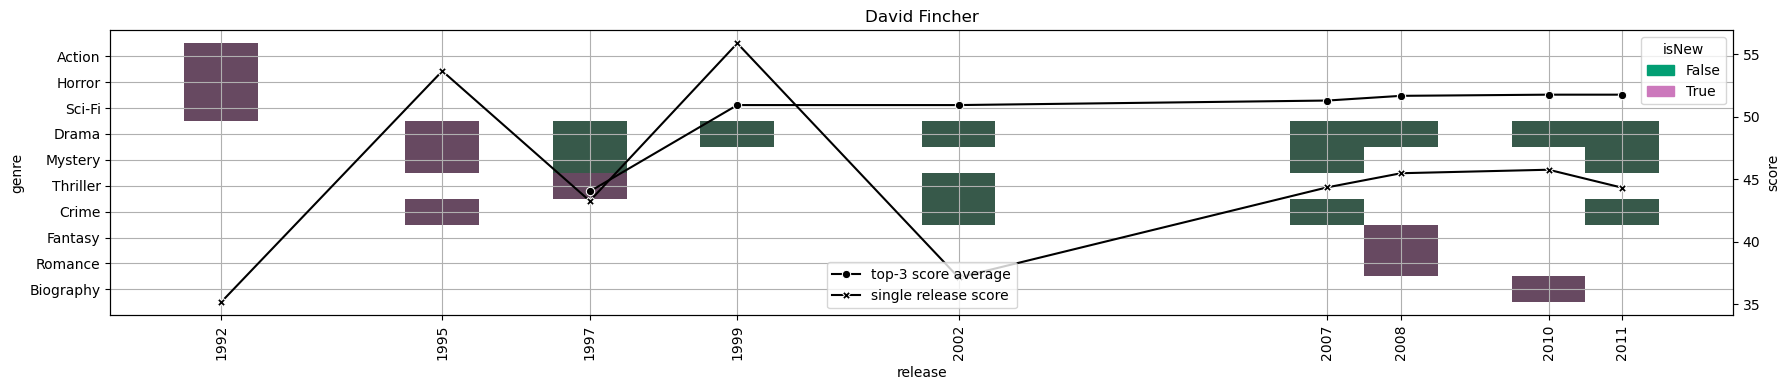

In [11]:
_ = plot_genre_evolution(directors.loc['nm0000399'])

# Correlations

## Prepare the dataframes

In [12]:
def standardize(s: pd.Series) -> pd.Series:
    return (s - s.mean()) / s.std()

In [13]:
movies_cor = movies.drop(['title', 'wikipediaID', 'freebaseID', 'revenue', 'isAdult', 'runtime', 'genres'], axis=1).copy()
# Drop empty strings
movies_cor.drop(movies_cor[movies_cor.languages == ''].index, inplace=True)
movies_cor.drop(movies_cor[movies_cor.countries == ''].index, inplace=True)
# Drop NA values
movies_cor.loc[movies_cor.languages == '', 'languages'] = 'multiple'
movies_cor.dropna(inplace=True)
# Reduce multiple values to 1
movies_cor.loc[movies_cor.languages.str.split(',').apply(len) > 1, 'languages'] = 'multilingual'
movies_cor.loc[movies_cor.countries.str.split(',').apply(len) > 1, 'countries'] = 'international'
movies_cor.loc[movies_cor.directors.str.split(',').apply(len) > 1, 'directors'] = 'multiple'
# Correct faulty languages
movies_cor.loc[movies_cor.languages == 'France', 'languages'] = 'French'
movies_cor.loc[movies_cor.languages == 'Japan', 'languages'] = 'Japanese'
# Convert data types
movies_cor.directorNewGenre = movies_cor.directorNewGenre.astype(int)
movies_cor.directorCareerYears = movies_cor.directorCareerYears.astype(int)
# Get one-hot representation for genres, countries, and languages
movies_cor = pd.concat([movies_cor, pd.get_dummies(movies_cor.languages, prefix='Language', dtype=int), pd.get_dummies(movies_cor.countries, prefix='Country', dtype=int)], axis=1)
for genre in IMDB_GENRES:
    movies_cor[f'Genre_{genre}'] = movies_cor.genres_imdb.str.contains(genre).astype(int)
movies_cor.rename(columns={colname: colname.replace(' ', '') for colname in movies_cor.columns}, inplace=True)
movies_cor.rename(columns={colname: colname.replace('-', '_') for colname in movies_cor.columns}, inplace=True)
movies_cor.drop(['countries', 'languages', 'genres_imdb'], axis=1, inplace=True)
# Set the type of the features
continuous_features = {
    'release', 'runtime_imdb', 'directorCareerYears',
    'awardsNominated', 'awardsWon', 'score', 'votes', 'rating'
}
# Standardize the continuous features
for f in continuous_features:
    movies_cor[f] = standardize(movies_cor[f])
    movies_cor[f] = movies_cor[f].astype(float)

Let's add another column that determines whether the directors is successful or not:

In [14]:
directors_successful = directors[directors['avg-3'] > 40].index.tolist()
movies_cor['directorIsSuccessful'] = movies_cor.apply(lambda row: any([d in directors_successful for d in row.directors.split(',')]), axis=1)


## Correlation between a director’s critical success and evolution of their style regarding movie genres


Not easy to quantize "evolution of their style."

## To what extent do directors experiment with new genres and thematics over the course of their career, and is there a pattern of periods of experimentation followed by periods of consistency 



In [128]:
len(directors[directors['avg-3'] > 40] )

135

In [15]:
print('*' * 100)
print('Correlations among all directors:')
print('*' * 100)
print(' ' * 100)
model = smf.ols('directorNewGenre ~  directorCareerYears', data=movies_cor).fit()
print(model.summary())

print(' ' * 100)

print('*' * 100)
print('Correlations among successful directors:')
print('*' * 100)
print(' ' * 100)
model = smf.ols('directorNewGenre ~  directorCareerYears', data=movies_cor.query('directorIsSuccessful')).fit()
print(model.summary())
print(' ' * 100)

****************************************************************************************************
Correlations among all directors:
****************************************************************************************************
                                                                                                    
                            OLS Regression Results                            
Dep. Variable:       directorNewGenre   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                 1.412e+04
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:21:56   Log-Likelihood:                -28159.
No. Observations:               52447   AIC:                         5.632e+04
Df Residuals:                   52445   BIC:                         5.634e+04
Df Model:                      

In [16]:
movies.directorCareerYears.mean(), movies.directorCareerYears.std()

(7.480320037513555, 9.282387540441137)

> Intercept: Probability of exploring a new genre in a movie with average years through the career (~7 years).

> Coefficient: Increase in probability with 1 std (~9 years) more through the career.

> There is a negative significant correlation.

The negative correlation might be due to the fact that in the first years, every genre is considered a new genre.

Let's do the same analysis considering only movies after a decade (1 std) through the career of the directors.

In [129]:
model = smf.ols('directorNewGenre ~  directorCareerYears', data=movies_cor.query('directorCareerYears > 0')).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       directorNewGenre   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     647.9
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.31e-140
Time:                        19:44:52   Log-Likelihood:                -13521.
No. Observations:               19341   AIC:                         2.705e+04
Df Residuals:                   19339   BIC:                         2.706e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5380    

[Text(0.5, 0, 'Career years of the director'),
 Text(0, 0.5, 'Probability of trying a new genre'),
 (0.0, 60.0)]

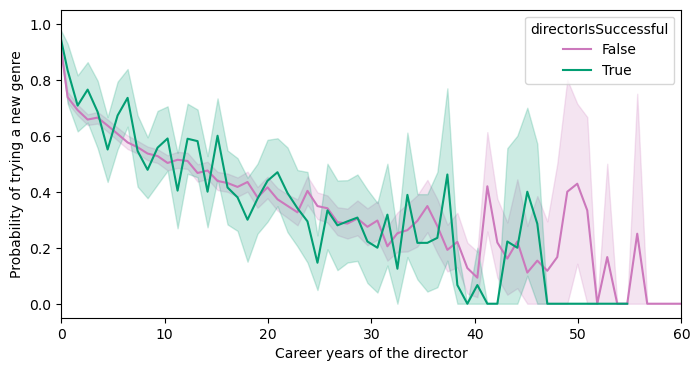

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

career_years_std = movies.directorCareerYears.dropna().std()
career_years_mean = movies.directorCareerYears.dropna().mean()
sns.lineplot(
    ax=ax,
    x=movies_cor.directorCareerYears * career_years_std + career_years_mean,
    y=movies_cor.directorNewGenre,
    hue=movies_cor.directorIsSuccessful,
    palette=PALETTE_D[:2],
)
ax.set(
    xlabel='Career years of the director',
    ylabel='Probability of trying a new genre',
    xlim=[0, 60],
)

> Not surprisingly, there is general trend of less tendency to try a new genre as the years pass in a director's career.

## Are directors who tend to work on more diverse projects less successful or more successful?

In [19]:
def get_num_genres(director):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(director.name)]
    return int(director_movies.directorNewGenre.sum())

def get_avg_num_genres_per_movie(director):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(director.name)]
    return director_movies.genres_imdb.dropna().str.split(',').apply(len).mean()

In [20]:
directors['genresPerMovie'] = directors.apply(get_avg_num_genres_per_movie, axis=1)
directors['genresExplored'] = directors.apply(get_num_genres, axis=1)

> Running this cell took 10 minutes.

In [21]:
directors_cor = directors.copy()

# Prepare the avg3 score
directors_cor = directors_cor.dropna(subset=['avg-3', 'genresExplored'])
directors_cor = directors_cor.rename(columns={'avg-3': 'avg3',})
directors_cor.avg3 = directors_cor.avg3.astype(float)

In [95]:
model = smf.ols('avg3 ~ genresPerMovie + genresExplored', data=directors_cor).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   avg3   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     802.2
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          4.00e-312
Time:                        19:05:30   Log-Likelihood:                -21999.
No. Observations:                6505   AIC:                         4.400e+04
Df Residuals:                    6502   BIC:                         4.402e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.8017      0.382     20.

[Text(0.5, 0, 'Avg. genres per movie')]

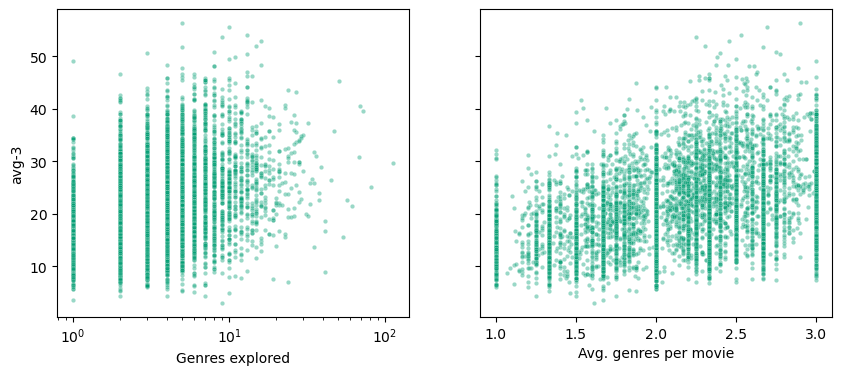

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.scatterplot(ax=axs[0], data=directors_cor, x='genresExplored', y='avg3', color=PALETTE_D[1], alpha=.4, s=10)
sns.scatterplot(ax=axs[1], data=directors_cor, x='genresPerMovie', y='avg3', color=PALETTE_D[1], alpha=.4, s=10)
axs[0].set(xscale='log', ylabel='avg-3', xlabel='Genres explored')
axs[1].set(xlabel='Avg. genres per movie')

> Doesn't really look like a meaningful correlation

In [26]:
model = smf.ols('awardsNominated ~ genresPerMovie + genresExplored', data=directors_cor).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        awardsNominated   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     16.60
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           6.47e-08
Time:                        18:32:31   Log-Likelihood:                -31158.
No. Observations:                6505   AIC:                         6.232e+04
Df Residuals:                    6502   BIC:                         6.234e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.7994      1.563      5.

> Nothing interesting, very low R-squared.

In [27]:
model = smf.ols('awardsWon ~ genresPerMovie + genresExplored', data=directors_cor).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              awardsWon   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.19
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.91e-06
Time:                        18:32:31   Log-Likelihood:                -26248.
No. Observations:                6505   AIC:                         5.250e+04
Df Residuals:                    6502   BIC:                         5.252e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.4011      0.735      7.

> Nothing interesting, very low R-squared.

## Is it less likely or more likely for a movie to succeed when the director tries a new genre?

There are many cofounders that could directly or indirectly impact the success of a movie. Runtime of the movie, release year, languages, production countries, genres, director, and cast could be the principal ones, among many other factors. For the purpose of this study, it is not possible to take into account all these factors, but we try to balance the dataset on the cofounders that we have data about.

We match exactly on director, genre, country, and language, and use propensity scores for matching on all the other features.

In [29]:
movies_cor_balanced_newgenre = movies_cor.copy()

In [30]:
# Set the continuous predictors
continuous_features_predictor = continuous_features.copy()
continuous_features_predictor.remove('awardsNominated')
continuous_features_predictor.remove('awardsWon')
continuous_features_predictor.remove('score')
continuous_features_predictor.remove('votes')
continuous_features_predictor.remove('rating')
continuous_features_predictor = list(continuous_features_predictor)

# Instantiate and fit the model
formula = 'directorNewGenre ~ ' + ' + '.join(continuous_features_predictor)
mod = smf.logit(formula=formula, data=movies_cor_balanced_newgenre)
res = mod.fit(maxiter=50, method='bfgs')
movies_cor_balanced_newgenre['propensityScore'] = res.predict()

Optimization terminated successfully.
         Current function value: 0.513099
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17


In [31]:
# Set categorical features to do exact matching on
categorical_features_exactmatch = (
    [c for c in movies_cor_balanced_newgenre.columns if c.startswith('Genre_')]
    + [c for c in movies_cor_balanced_newgenre.columns if c.startswith('Language_')]
    + [c for c in movies_cor_balanced_newgenre.columns if c.startswith('Country_')]
)

# Set control and treatment groups
control = movies_cor_balanced_newgenre.query('directorNewGenre == False')
treatment = movies_cor_balanced_newgenre.query('directorNewGenre == True')

# Create an empty graph
G = nx.Graph()

# Loop through all directors
for d in control.directors.unique():
    control_d = control.query('directors == @d')
    treatment_d = treatment.query('directors == @d')
    if d == 'multiple':
        continue
    # Loop through all the pairs of movies of this director
    for c_id, c in control_d.iterrows():
        for t_id, t in treatment_d.iterrows():
            # Skip if any categorical predictor is different
            if any(c[categorical_features_exactmatch] != t[categorical_features_exactmatch]):
                continue
            # Add an edge between the two movies weighted by the similarity between them
            similarity = 1 - np.abs(c['propensityScore'] - t['propensityScore'])
            G.add_edge(c_id, t_id, weight=similarity)

# Generate and return the maximum weight matching on the generated graph
pairs = nx.max_weight_matching(G, maxcardinality=True)
idx = [pair[0] for pair in list(pairs)] + [pair[1] for pair in list(pairs)]
movies_cor_balanced_newgenre = movies_cor_balanced_newgenre.loc[idx]

> Running this cell took 5 minutes.

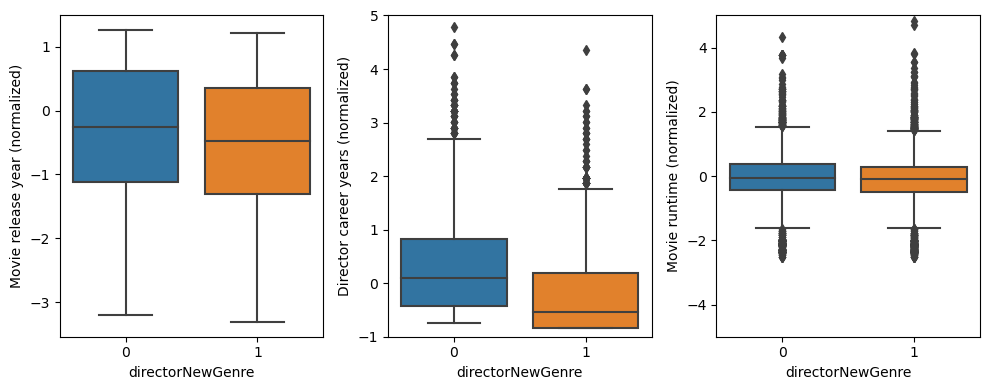

In [154]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

sns.boxplot(
    ax=axs.flatten()[0],
    y=movies_cor_balanced_newgenre.release,
    x=movies_cor_balanced_newgenre.directorNewGenre,
)
axs[0].set(ylabel='Movie release year (normalized)')

sns.boxplot(
    ax=axs.flatten()[1],
    y=movies_cor_balanced_newgenre.directorCareerYears,
    x=movies_cor_balanced_newgenre.directorNewGenre,
)
axs[1].set(ylabel='Director career years (normalized)', ylim=[-1, 5])

sns.boxplot(
    ax=axs.flatten()[2],
    data=movies_cor_balanced_newgenre,
    y=movies_cor_balanced_newgenre.runtime_imdb,
    x=movies_cor_balanced_newgenre.directorNewGenre,
)
axs[2].set(ylabel='Movie runtime (normalized)', ylim=[-5, 5])

plt.tight_layout()

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda/envs/dummy/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


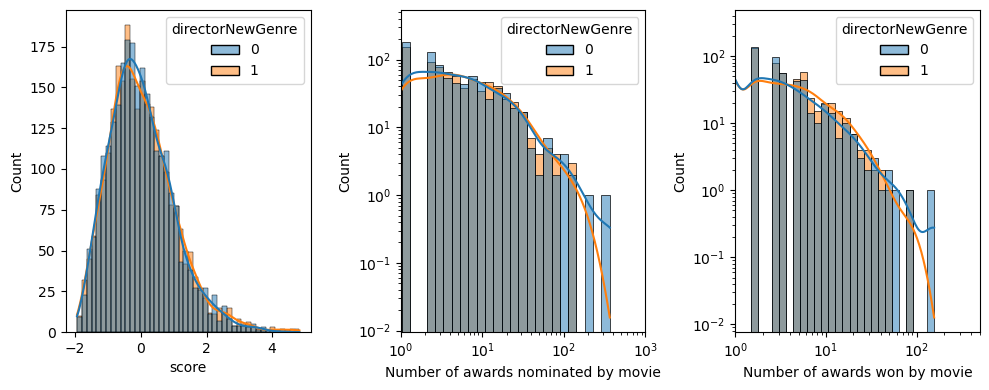

In [184]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

sns.histplot(
    ax=axs[0],
    data=movies_cor_balanced_newgenre,
    x='score',
    hue='directorNewGenre',
    kde=True,
)

sns.histplot(
    ax=axs[1],
    data=movies_cor_balanced_newgenre,
    x=(movies_cor_balanced_newgenre.awardsNominated * movies.awardsNominated.std() + movies.awardsNominated.mean()),
    hue='directorNewGenre',
    kde=True,
    log_scale=(True, True),
    bins=30,
)
axs[1].set(xlabel='Number of awards nominated by movie', xlim=[1, 1000])

sns.histplot(
    ax=axs[2],
    data=movies_cor_balanced_newgenre,
    x=(movies_cor_balanced_newgenre.awardsWon * movies.awardsWon.std() + movies.awardsWon.mean()),
    hue='directorNewGenre',
    kde=True,
    log_scale=(True, True),
    bins=30,
)
axs[2].set(xlabel='Number of awards won by movie', xlim=[1, 500])


plt.tight_layout()

First, let's do a t-test to check the average score of the control and the treatment group:

In [32]:
control = movies_cor_balanced_newgenre.query('directorNewGenre == False')
treatment = movies_cor_balanced_newgenre.query('directorNewGenre == True')
sp.stats.ttest_rel(control.score, treatment.score)

TtestResult(statistic=-1.2272720644791393, pvalue=0.21983044500720153, df=2624)

In [33]:
control = movies_cor_balanced_newgenre.query('directorNewGenre == False')
treatment = movies_cor_balanced_newgenre.query('directorNewGenre == True')
sp.stats.ttest_rel(control.awardsNominated, treatment.awardsNominated)

TtestResult(statistic=0.7976820392241377, pvalue=0.4251272069831761, df=2624)

In [34]:
control = movies_cor_balanced_newgenre.query('directorNewGenre == False')
treatment = movies_cor_balanced_newgenre.query('directorNewGenre == True')
sp.stats.ttest_rel(control.awardsWon, treatment.awardsWon)

TtestResult(statistic=-0.6543718597399005, pvalue=0.5129296074739128, df=2624)

> High p-value means that we cannot reject the null hypothesis that they both have the same average.

In [35]:
model = smf.ols('score ~ C(directorNewGenre)', data=movies_cor_balanced_newgenre).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.485
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.223
Time:                        18:34:34   Log-Likelihood:                -7412.6
No. Observations:                5250   AIC:                         1.483e+04
Df Residuals:                    5248   BIC:                         1.484e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [36]:
model = smf.ols('awardsWon ~ C(directorNewGenre)', data=movies_cor_balanced_newgenre).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              awardsWon   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4234
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.515
Time:                        18:34:34   Log-Likelihood:                -6453.6
No. Observations:                5250   AIC:                         1.291e+04
Df Residuals:                    5248   BIC:                         1.292e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [37]:
model = smf.ols('awardsNominated ~ C(directorNewGenre)', data=movies_cor_balanced_newgenre).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        awardsNominated   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6304
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.427
Time:                        18:34:34   Log-Likelihood:                -6298.3
No. Observations:                5250   AIC:                         1.260e+04
Df Residuals:                    5248   BIC:                         1.261e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [38]:
model = smf.ols('votes ~ C(directorNewGenre)', data=movies_cor_balanced_newgenre).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  votes   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.093
Date:                Fri, 22 Dec 2023   Prob (F-statistic):             0.0787
Time:                        18:34:35   Log-Likelihood:                -7733.0
No. Observations:                5250   AIC:                         1.547e+04
Df Residuals:                    5248   BIC:                         1.548e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

> For all of them, the p-value is high, suggesting that such correlation does not exist.

# Graph analysis for genre-similarity

## Are more successful directors more often specialized in a certain combination of genres ?

### Define base algorithms and plotting functions

In [39]:
def get_bipartite_graph(movies, genres=None, directors=None):
    """Creates a tripartite graph with directors, movies, and genres."""

    # Drop NAs
    movies = movies.dropna(subset='genres_imdb')

    # Get all the genres
    if genres is None:
        genres = []
        for x in movies.genres_imdb.str.split(',').dropna(): genres.extend(x)

    # Get all the directors
    if directors is None:
        movies = movies.dropna(subset='directors')
        directors = []
        for x in movies.directors.str.split(',').dropna(): directors.extend(x)

    # Create the graph
    G = nx.Graph()
    for tconst, movie in movies.iterrows():
        G.add_node(tconst, part=0, n_genres=len(movie.genres_imdb.split(',')))
    G.add_nodes_from(set(genres), part=1)
    G.add_nodes_from(set(directors), part=2)
    nodes_movies = {n for n, d in G.nodes(data='part') if d == 0}
    nodes_genres = {n for n, d in G.nodes(data='part') if d == 1}
    nodes_directors = {n for n, d in G.nodes(data='part') if d == 2}
    for tconst, m in movies.iterrows():
        G.add_edges_from([(tconst, g) for g in m.genres_imdb.split(',')])
        G.add_edges_from([(tconst, d) for d in m.directors.split(',')])

    return G, nodes_movies, nodes_genres, nodes_directors

In [40]:
def draw_bipartite_graph(B, nodes_left, nodes_right):
    """Draws a bipartite graph."""

    pos = nx.bipartite_layout(G=B, nodes=nodes_left)
    nx.draw(G=B, with_labels=False, pos=pos, alpha=.5)
    nx.draw_networkx_labels(
        G=B,
        pos=pos,
        labels={n: n for n in nodes_right},
        font_size=12,
        font_color='k',
    )
    plt.show()

In [186]:
def draw_weighted_graph(
    G, layout = None, with_labels: bool = False,
    normalize_wights: bool = False, labels: dict = None,
    scale_edges: bool = True,
    scale_nodes: bool = True,
    return_fig: bool = False,
):
    """Draws a weighted graph."""

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Set the layout
    if layout is None:
        layout = nx.spring_layout(G)

    # Draw the edges
    weights = list(nx.get_edge_attributes(G, 'weight').values())
    for (u, v, w) in G.edges(data='weight'):
        if normalize_wights:
            if max(weights) == min(weights):
                w = 1
            else:
                w = (w - min(weights)) / (max(weights) - min(weights))
        nx.draw_networkx_edges(G,
            pos=layout,
            edgelist=[(u, v)],
            alpha=w,
            width=(10*w if scale_edges else 1),
            edge_color='k',
            ax=ax,
        )

    # Draw the nodes
    node_size = 2000
    if scale_nodes:
        sizes = np.array(list(nx.get_node_attributes(G, 'prevelance').values()))
        if max(sizes) == min(sizes):
            sizes = 0
        else:
            sizes = (sizes - min(sizes)) / (max(sizes) - min(sizes))
        sizes = 0.01 + 0.8 * sizes
    nx.draw_networkx_nodes(G,
        pos=layout,
        nodelist=G.nodes,
        node_size=(node_size*sizes if scale_nodes else node_size),
        node_color=PALETTE_D[0],
        ax=ax,
    )

    # Draw the labels
    if with_labels or labels:
        nx.draw_networkx_labels(G,
            pos=layout,
            labels=labels,
            font_size=8,
            font_color='#616161',
            # bbox={'facecolor': 'k', 'alpha': .2, 'edgecolor': 'none'},
            ax=ax,
        )

    if return_fig:
        return fig
    else:
        plt.show()

### Co-existence of genres for a group of directors

Let's project the bipartite graph on movies to find the connection between different genres.

In [42]:
def get_genre_coexistence_graph(movies, directors = None, verbose: bool = True):
    """Returns a weighted graph of genres based on their co-existence in movies of a set of directors."""

    # Get a tripartite graph
    if directors is not None:
        movies = movies.dropna(subset='directors')
        movies = movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))]
        if verbose:
            print(f'Considering movies of {len(directors)} directors.')
    if verbose:
        print(f'Considering {len(movies)} movies.')
    B, _, nodes_genres, _ = get_bipartite_graph(
        movies=movies,
        genres=None,
        directors=directors.index if (directors is not None) else None,
    )

    # Project the graph on movies
    MG = nx.bipartite.projected_graph(B, nodes_genres, multigraph=True)
    # Omit the directors
    MG = MG.subgraph(nodes_genres)

    # Add nodes with their prevelance
    G = nx.Graph()
    G.add_nodes_from(IMDB_GENRES, prevelance=0)
    prevelances = {n: B.degree[n] for n in nodes_genres}
    nx.set_node_attributes(G, values=prevelances, name='prevelance')
    # Reduce multiple edges to a weighted edge
    for u in nodes_genres:
        for v in nodes_genres:
            if u is v: continue
            G.add_edge(u, v, weight=MG.number_of_edges(u, v))

    return G

Considering 73738 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


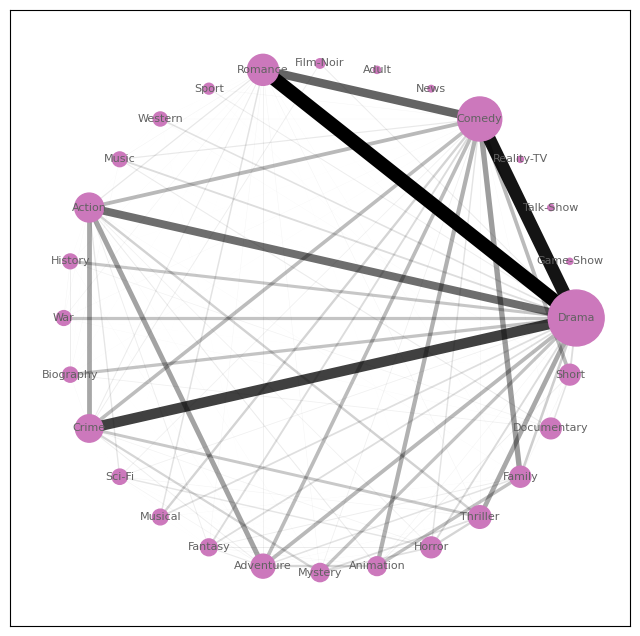

In [43]:
G = get_genre_coexistence_graph(movies=movies)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout=layout, with_labels=True, normalize_wights=True)

> This can done in 3s, a very nice candidate for an interactive plot.

> With all movies it takes 30s.

Let's look at this plot for several countries:

Considering movies of 932 directors.
Considering 4 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


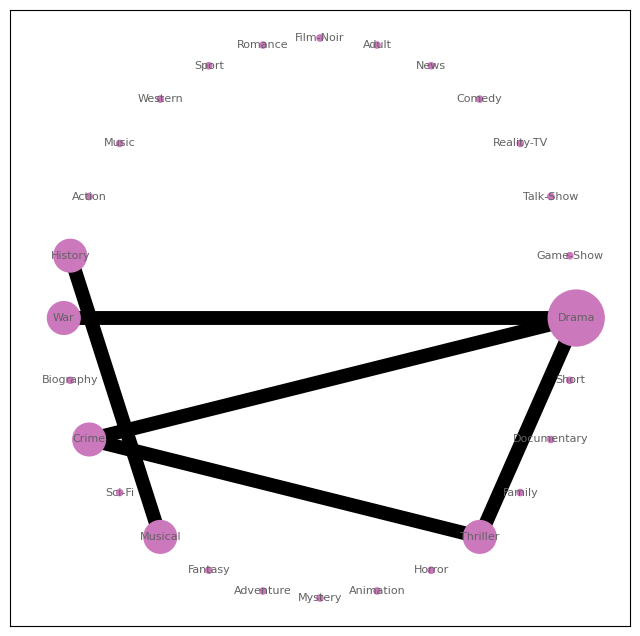

In [198]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('Algeria')],
    directors=directors[directors['avg-3'] > 30],
)

layout = nx.circular_layout(G)
draw_weighted_graph(G, layout=layout, with_labels=True, normalize_wights=True, scale_nodes=True)

In [188]:
countries = set(sorted([country.strip() for sublist in movies.countries.str.split(',') for country in sublist]))
countries.remove('')

In [ ]:
# Generate and save plots
countries_exclude = []
for country in tqdm.tqdm(countries):
    df = movies[movies.countries.str.contains(country) & ~movies.countries.str.contains(',')]
    if not len(df):
        countries_exclude.append(country)
        continue
    G = get_genre_coexistence_graph(
        movies=df,
        verbose=False,
    )
    layout = nx.circular_layout(G)
    fig = draw_weighted_graph(G, layout=layout, with_labels=True, normalize_wights=True, scale_nodes=True, return_fig=True)
    fig.savefig(f"docs/assets/figs/genre_coexistence_graphs/{country}.png", bbox_inches='tight')
    plt.clf()
    plt.close()

# Generate html body with options
html_options = ['<option value="">Select a country</option>']
for country in sorted(countries):
    if country in countries_exclude:
        continue
    selected_attribute = ' selected' if country == "Argentina" else ''
    option = f'<option value="{country}"{selected_attribute}>{country}</option>'
    html_options.append(option)

# Join all options to form the final HTML string
html_scores_votes_countries = '\n    '.join(html_options)

In [ ]:
year_ranges = [
    (1800, 1900), (1900, 1910), (1910, 1920),
    (1920, 1930), (1930, 1940), (1940, 1950),
    (1950, 1960), (1960, 1970), (1970, 1980),
    (1980, 1990), (1990, 2000), (2000, 2010),
    (2010, 2020),
]

for year_min, year_max in tqdm.tqdm(year_ranges):
    rng = f'{year_min}-{year_max}'
    df = movies[(movies.release < year_max) & (movies.release >= year_min)]
    G = get_genre_coexistence_graph(
        movies=df,
        verbose=False,
    )
    layout = nx.circular_layout(G)
    fig = draw_weighted_graph(G, layout=layout, with_labels=True, normalize_wights=True, scale_nodes=True, return_fig=True)

    fig.savefig(f"docs/assets/figs/genre_coexistence_graphs/{rng}.png", bbox_inches='tight')
    plt.clf()
    plt.close()

# Generate html body with options
html_options = ['<option value="">Select a country</option>']
for year_min, year_max in year_ranges:
    rng = f'{year_min}-{year_max}'
    option = f'<option value="{rng}">{rng}</option>'
    html_options.append(option)

# Join all options to form the final HTML string
html_scores_votes_countries = '\n    '.join(html_options)

### Genre-similarity score of a set of movies

Now, let's project the plot on genres and then get a similarity measure for directors:

In [45]:
def get_similarity_score(movies, directors = None, verbose: bool = True):
    """
    Calculates a single similarity score of the movies of one or more directors
    based on the density of the projection graph.
    """

    # Get a tripartite graph
    if directors is not None:
        movies = movies.dropna(subset='directors')
        movies = movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))]
        if verbose:
            print(f'Considering movies of {len(directors)} directors.')
    if verbose:
        print(f'Considering {len(movies)} movies.')
    B, nodes_movies, nodes_genres, _ = get_bipartite_graph(
        movies=movies,
        genres=None,
        directors=directors.index if (directors is not None) else None,
    )

    # Project the graph on genres
    MG = nx.bipartite.projected_graph(B.subgraph(nodes_movies.union(nodes_genres)), nodes_movies, multigraph=True)

    # Reduce multiple edges to a weighted edge
    G = nx.Graph()
    G.add_nodes_from(nodes_movies)
    for u in nodes_movies:
        for v in nodes_movies:
            if u is v: continue
            max_num_edges = min([n for _, n in B.subgraph(nodes=[u, v]).nodes(data='n_genres')])
            w = MG.number_of_edges(u, v) / max_num_edges
            G.add_edge(u, v, weight=w)

    # Calculate the density of the weighted graph
    n = G.number_of_nodes()
    m = np.array(list(nx.get_edge_attributes(G, 'weight').values())).sum()
    score = 2 * m / (n * (n-1))

    return score

> We can quantify the similarity of movies of a group of directors, and compare these numbers together.

First, let's have a baseline by sampling movies randomly:

In [46]:
for n in [10, 100, 500, 1000]:
    # Repeat the sampling and report the average
    score = 0
    repeats = 5
    for _ in range(repeats):
        score += get_similarity_score(movies=movies.sample(n), verbose=False)
    score /= repeats
    print(f'Expected similarity of {n} random movies: {score:.4f}')

Expected similarity of 10 random movies: 0.3741
Expected similarity of 100 random movies: 0.3122
Expected similarity of 500 random movies: 0.3229
Expected similarity of 1000 random movies: 0.3059


Let's do that for movies of random directors (among the ones with at least 10 movies) to get an expected upper bound:

In [47]:
score = 0
repeats = 100
for _ in range(repeats):
    score += get_similarity_score(movies=movies, directors=directors.dropna(subset='avg-10').sample(1), verbose=False)
score /= repeats
print(f'Expected similarity of the movies of a director: {score:.4f}')

Expected similarity of the movies of a director: 0.5449


> A similarity score of around `0.3` is considered as the baseline.

> A similarity score of around `0.53` is considered as a high value.

#### Let's do that for top directors:

In [48]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['avg-3'] >= 40],
)

Considering movies of 135 directors.
Considering 2324 movies.


0.32765550935968507

> Nothing interesting.

In [49]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['avg-3'] >= 50],
)

Considering movies of 10 directors.
Considering 191 movies.


0.2828419215578213

> Nothing interesting.

In [50]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['avg-10'] >= 40],
)

Considering movies of 18 directors.
Considering 418 movies.


0.26837668621083993

> Nothing interesting.

In [51]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['hits-50'] >= 1],
)

Considering movies of 48 directors.
Considering 530 movies.


0.2838320790384135

> Nothing interesting.

In [52]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['hits-45'] >= 2],
)

Considering movies of 38 directors.
Considering 730 movies.


0.28392368353471015

> Nothing interesting.

In [53]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['hits-40'] >= 5],
)

Considering movies of 21 directors.
Considering 491 movies.


0.2727808027487981

> No significant similarity when we check top directors.

In [54]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['rate-8.0'] >= 10],
)

Considering movies of 7 directors.
Considering 432 movies.


0.3904638572636198

> Similarity between directors with many high-rated movies!!

> Let's check which genres these are.

Considering movies of 7 directors.
Considering 432 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


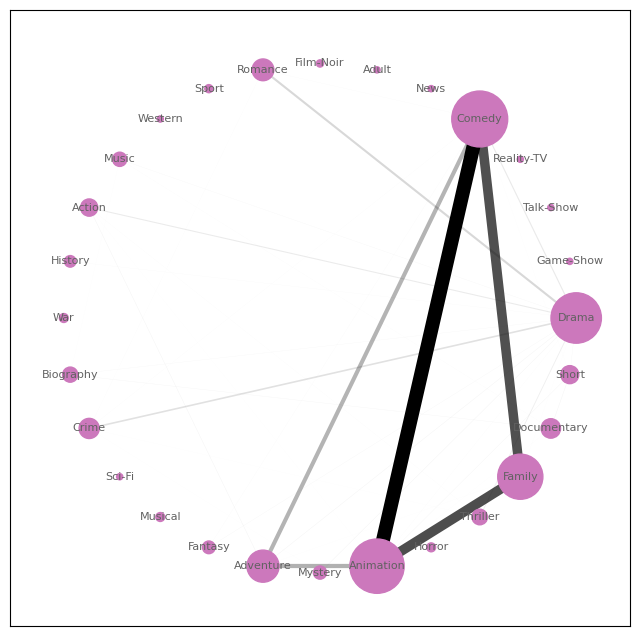

In [55]:
G = get_genre_coexistence_graph(
    movies=movies,
    directors=directors[directors['rate-8.0'] >= 10],
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

In [56]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['rate-8.5'] >= 3],
)

Considering movies of 14 directors.
Considering 269 movies.


0.40111241545083565

> Again, similarity beteween directors with three or more brilliant movies.

Considering movies of 14 directors.
Considering 269 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


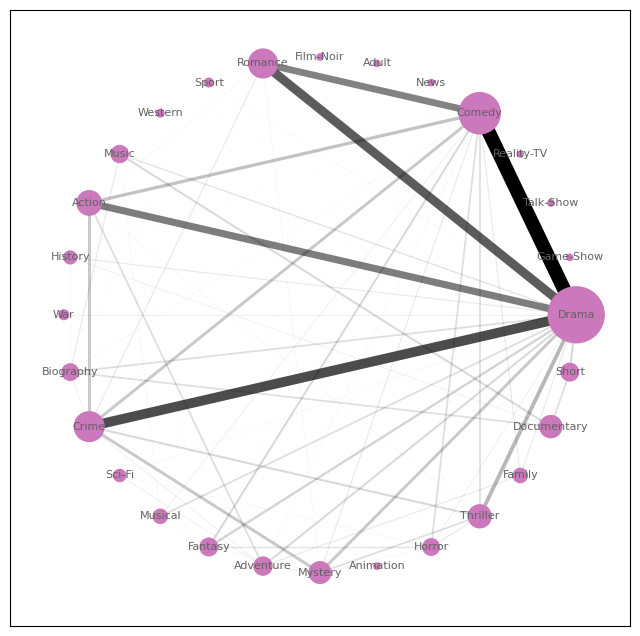

In [57]:
G = get_genre_coexistence_graph(
    movies=movies,
    directors=directors[directors['rate-8.5'] >= 3],
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

#### Now let's do the same for the most award-winning directors and movies:

In [58]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['awardsNominated'] >= 150],
)

Considering movies of 66 directors.
Considering 646 movies.


0.4225598195214439

Considering movies of 66 directors.
Considering 646 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


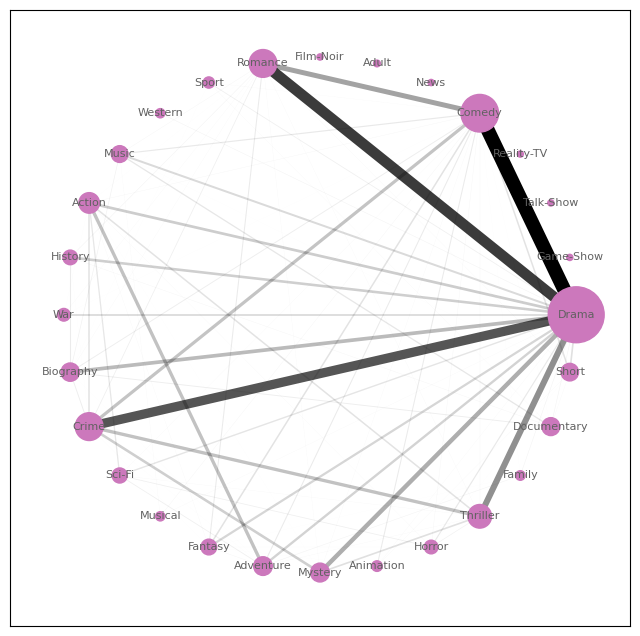

In [59]:
G = get_genre_coexistence_graph(
    movies=movies,
    directors=directors[directors['awardsNominated'] >= 150],
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

In [60]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['awardsWon'] >= 50],
)

Considering movies of 181 directors.
Considering 1785 movies.


0.4434286719171974

Considering movies of 181 directors.
Considering 1785 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


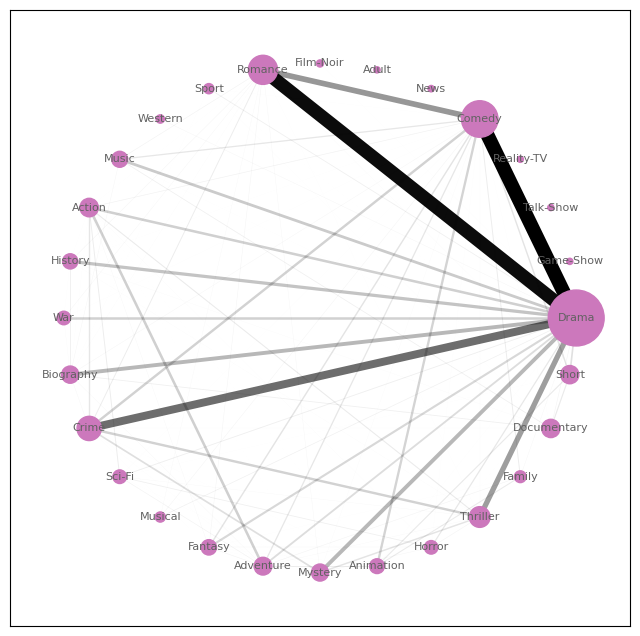

In [61]:
G = get_genre_coexistence_graph(
    movies=movies,
    directors=directors[directors['awardsWon'] >= 50],
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

In [62]:
get_similarity_score(
    movies=movies.query('awardsNominated > 30'),
)

Considering 1217 movies.


0.45002901151811314

Considering 1217 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


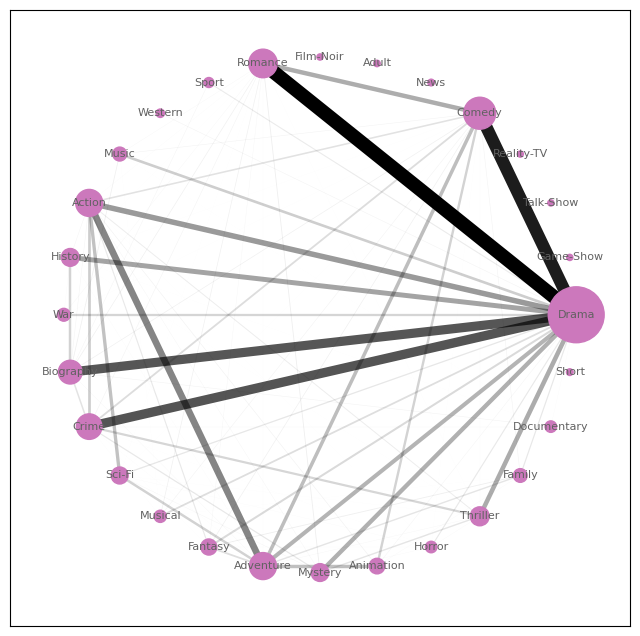

In [63]:
G = get_genre_coexistence_graph(
    movies=movies.query('awardsNominated > 30'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

In [64]:
get_similarity_score(
    movies=movies.query('awardsWon > 10'),
)

Considering 1842 movies.


0.50312246703795

Considering 1842 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


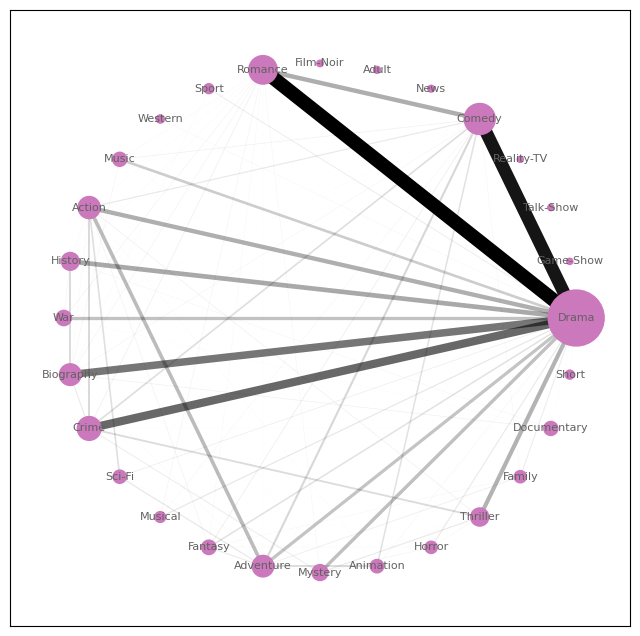

In [65]:
G = get_genre_coexistence_graph(
    movies=movies.query('awardsWon > 10'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

#### Now let's do the same for the most popular movies:

In [66]:
get_similarity_score(
    movies=movies.query('votes > 100_000'),
)

Considering 1697 movies.


0.28122150910041027

> Okay, nothing really interesting here.

In [67]:
get_similarity_score(movies=movies.query('votes > 1000_000'))

Considering 63 movies.


0.3724185014507595

In [68]:
get_similarity_score(movies=movies.query('votes > 1500_000'))

Considering 19 movies.


0.5565302144249512

> Seems like some genre combinations are more popular than the others!

Considering 63 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


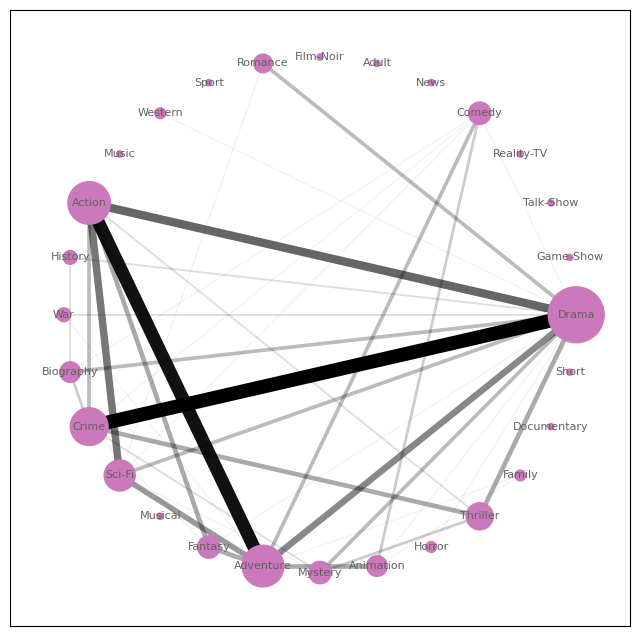

In [69]:
G = get_genre_coexistence_graph(movies=movies.query('votes > 1000_000'))
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

#### Let's do that for movies in different countries and languages:

##### Indian movies from award-winning directors

In [70]:
get_similarity_score(
    movies=movies[movies.countries.str.contains('India')],
    directors=directors.query('awardsWon > 10'),
)

Considering movies of 2185 directors.
Considering 555 movies.


0.5958430154042587

Considering movies of 2185 directors.
Considering 555 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


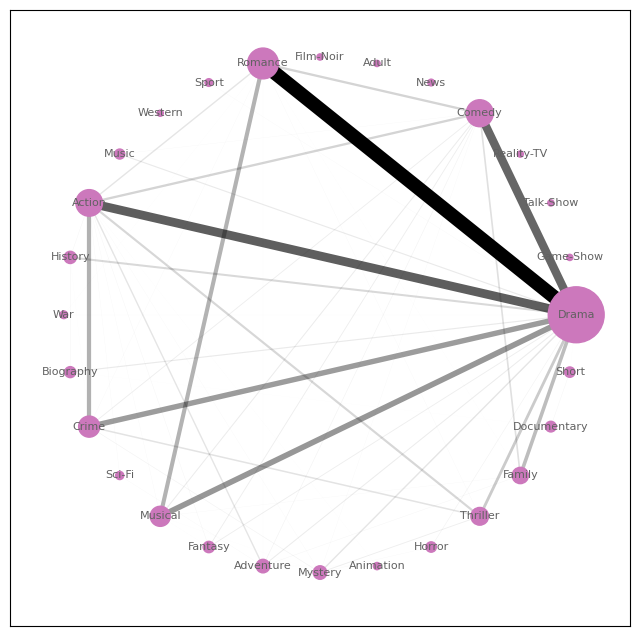

In [71]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('India')],
    directors=directors.query('awardsWon > 10'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

##### Turkish movies from award-winning directors

In [72]:
get_similarity_score(
    movies=movies[movies.countries.str.contains('Turkey')],
    directors=directors.query('awardsWon > 5'),
)

Considering movies of 4299 directors.
Considering 104 movies.


0.739824495892457

Considering movies of 4299 directors.
Considering 104 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


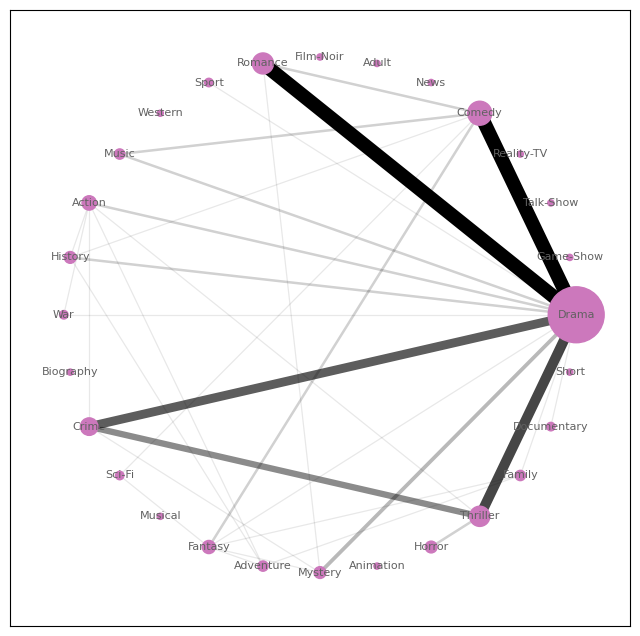

In [73]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('Turkey')],
    directors=directors.query('awardsWon > 5'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

##### Chinese movies from award-winning directors

In [221]:
get_similarity_score(
    movies=movies[movies.countries.str.contains('Canada')],
    directors=directors.query('awardsWon > 10'),
)

Considering movies of 2185 directors.
Considering 429 movies.


0.3460957526378087

Considering movies of 2185 directors.
Considering 300 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


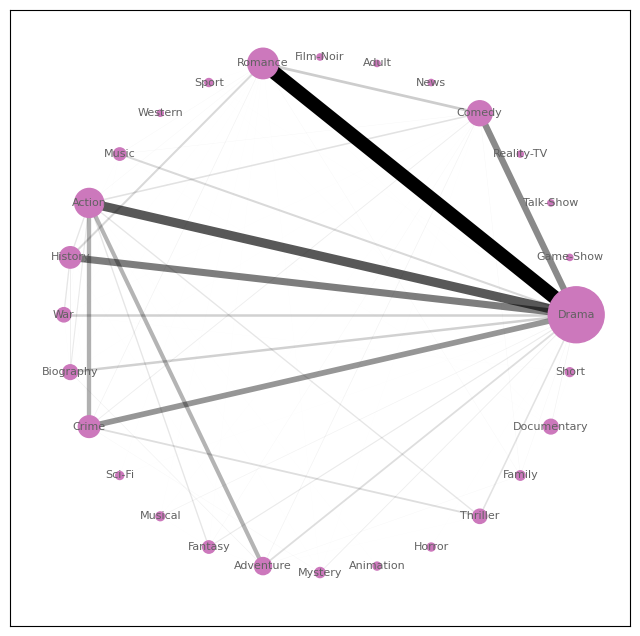

In [213]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('China')],
    directors=directors.query('awardsWon > 10'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

##### Korean movies from award-winning directors

In [214]:
get_similarity_score(
    movies=movies[movies.countries.str.contains('Korea')],
    directors=directors.query('awardsWon > 10'),
)

Considering movies of 2185 directors.
Considering 163 movies.


0.6057942970786638

Considering movies of 2185 directors.
Considering 163 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


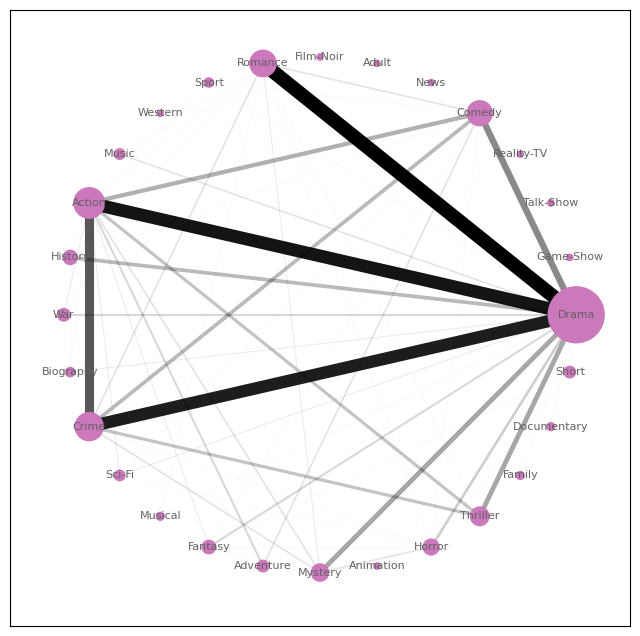

In [215]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('Korea')],
    directors=directors.query('awardsWon > 10'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

### Genre-similarity of a set of directors

In [78]:
def get_similarity_graph(movies, directors, verbose: bool = True):
    """Creates a weighted graph of directors based on the similarity of their movie genres."""

    # Get the tripartite graph
    movies = movies.dropna(subset='directors')
    movies = movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))]
    if verbose:
        print(f'Considering movies of {len(directors)} directors.')
        print(f'Considering {len(movies)} movies.')
    B, nodes_movies, nodes_genres, nodes_directors = get_bipartite_graph(
        movies=movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))],
        genres=None,
        directors=directors.index,
    )

    # Project the graph on genres (excluding the directors)
    MG = nx.bipartite.projected_graph(B.subgraph(nodes_movies.union(nodes_genres)), nodes_movies, multigraph=True)

    # Reduce multiple edges to a weighted edge
    G = nx.Graph()
    G.add_nodes_from(nodes_movies)
    for u in nodes_movies:
        for v in nodes_movies:
            if u is v: continue
            max_num_edges = min([n for _, n in B.subgraph(nodes=[u, v]).nodes(data='n_genres')])
            w = MG.number_of_edges(u, v) / max_num_edges
            G.add_edge(u, v, weight=w)

    # Make multigraph and add director nodes
    G = nx.MultiGraph(G)
    G.add_nodes_from(nodes_directors)

    # Remove movie nodes and create weighted edges between their directors
    for d in nodes_directors:
        for m in B[d].keys():
            for v, atts in G[m].items():
                # Continue if it's another movie of this director
                if v in B[d]: continue
                # Add the weighted edge otherwise
                w = atts[0]['weight']
                G.add_edge(d, v, weight=w)

    # Create the director's graph and add weighted edges
    D = nx.Graph()
    D.add_nodes_from(nodes_directors)
    for d1, d2 in [(d1, d2) for d1 in nodes_directors for d2 in nodes_directors]:
        if d1 == d2:
            continue
        sum_edges = np.array(list(nx.get_edge_attributes(G.subgraph([d1, d2]), 'weight').values())).sum()
        max_edges = len(B[d1]) * len(B[d2])
        w = sum_edges / max_edges if max_edges else 0
        D.add_edge(d1, d2, weight=w)

    return D

> Here, what we get is a fully-connected weighted graph, so basically a matrix. I'm not sure if it's a good idea to treat it as a graph.

In [79]:
def plot_adjacency_matrix(G, order = None):
    mat = nx.adjacency_matrix(G)
    if order is None:
        order = range(mat.shape[0])
    mat = mat[:, order][order].todense()
    plt.matshow(mat)

#### Let's first look at the similarity between the most brilliant directors

First, we do it for a few directors to get a sense

Considering movies of 14 directors.
Considering 271 movies.


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


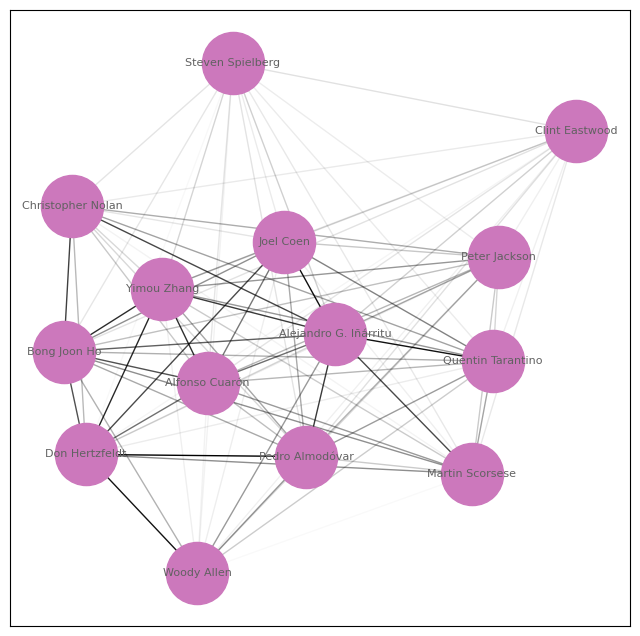

In [80]:
D = get_similarity_graph(
    movies=movies,
    directors=directors.query('awardsWon > 120'),
)

if len(D.nodes) <= 40:
    # Plot the graph
    layout = nx.spring_layout(D)
    labels = {n: directors.loc[n].primaryName for n in D.nodes}
    draw_weighted_graph(D, layout=layout, normalize_wights=True, labels=labels, scale_edges=False, scale_nodes=False)

We can Look at the weighted degree centrality of these directors to find the legendary directors with unique styles:

<Axes: xlabel='centrality', ylabel='name'>

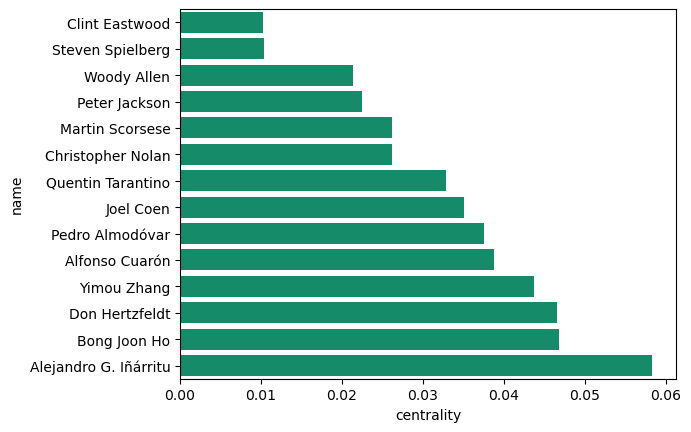

In [81]:
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality')
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
sns.barplot(df, x='centrality', y='name', color=PALETTE_D[1])

Now let's do that for more directors

Considering movies of 174 directors.
Considering 1717 movies.


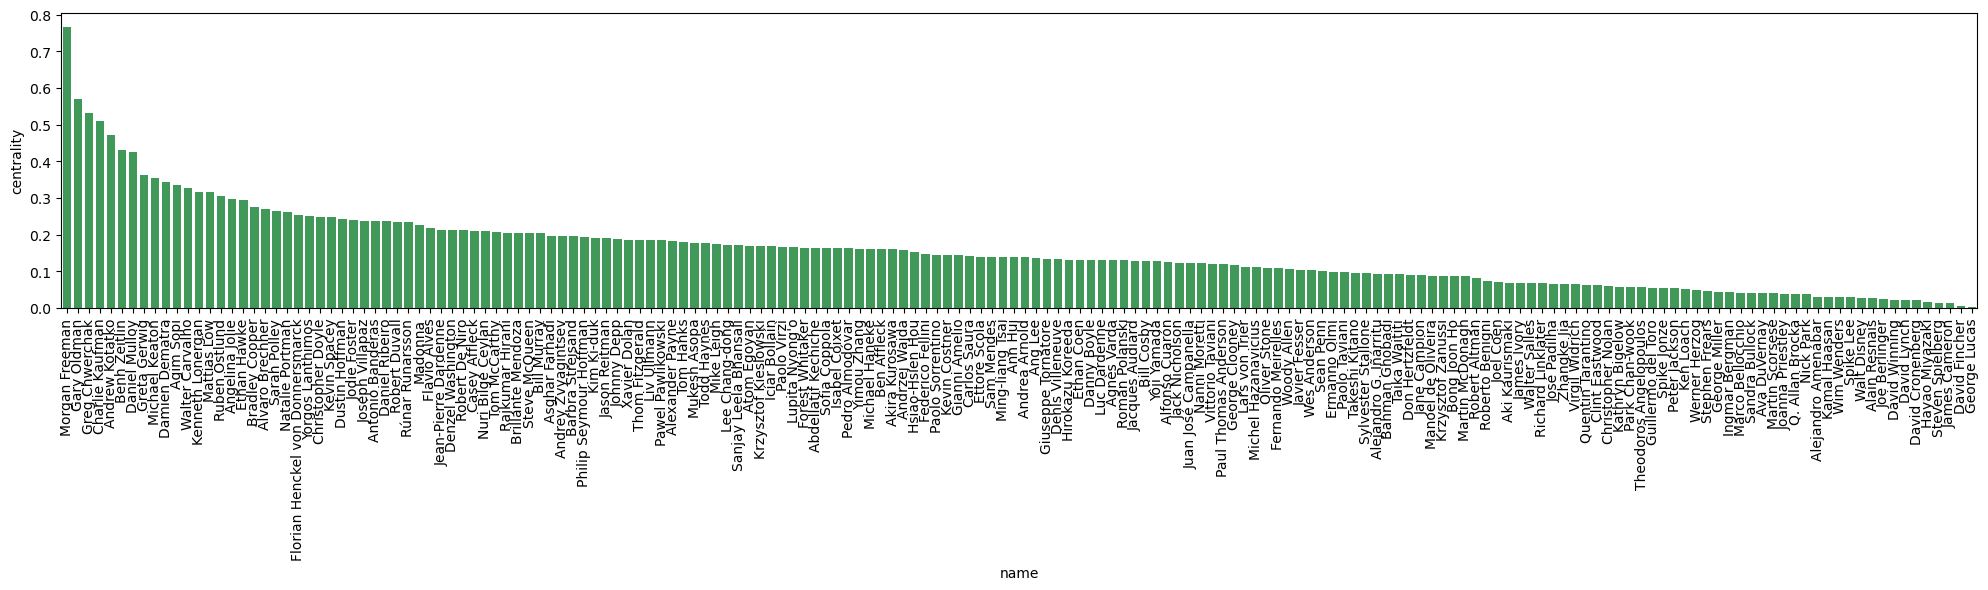

In [223]:
D = get_similarity_graph(
    movies=movies,
    directors=directors.query('awardsWon > 50'),
)
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality', ascending=False)
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(df, y='centrality', x='name', color='#32a852', ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

Considering movies of 121 directors.
Considering 1173 movies.


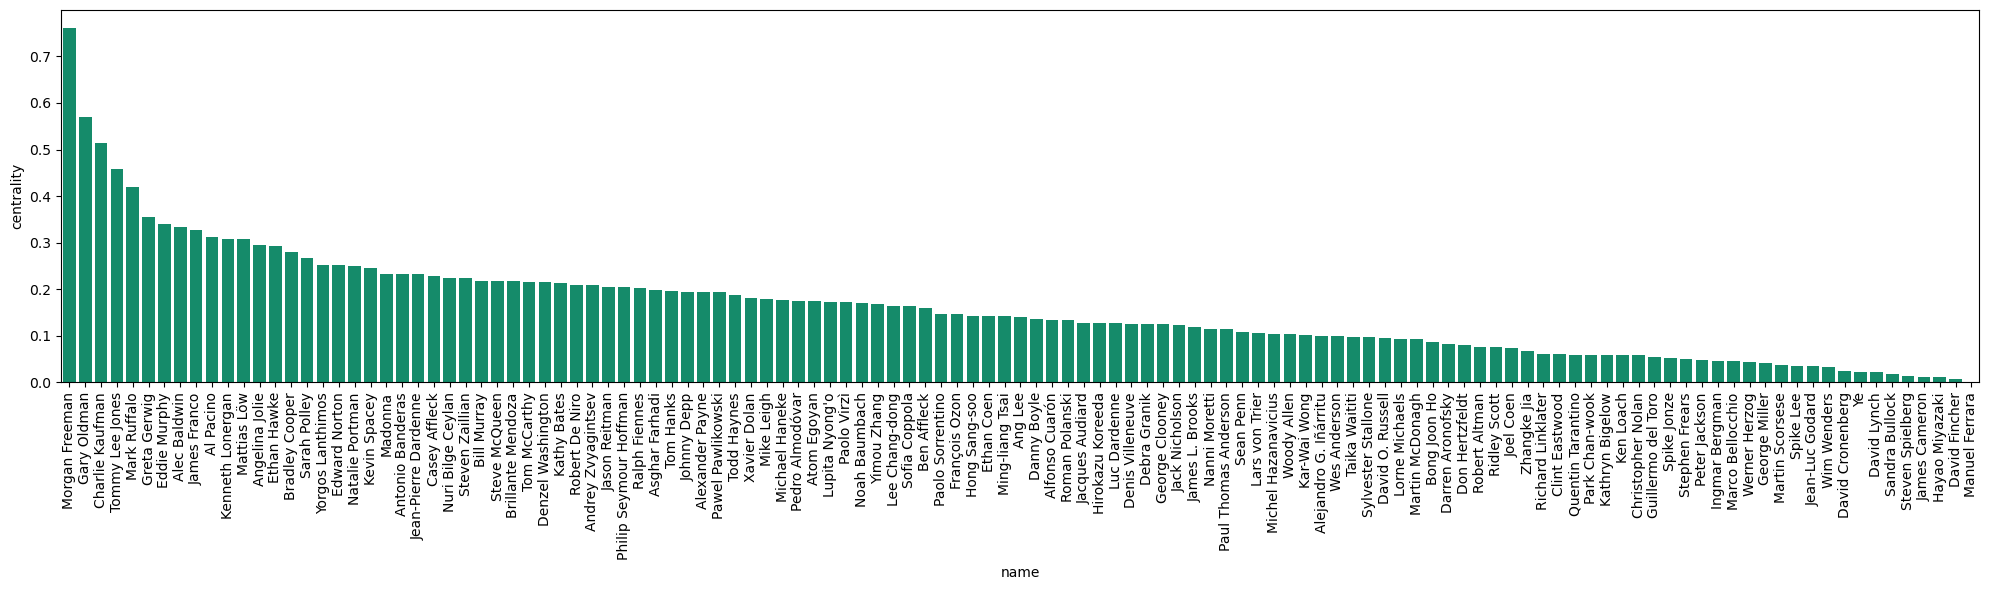

In [83]:
D = get_similarity_graph(
    movies=movies,
    directors=directors.query('awardsNominated > 120'),
)
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality', ascending=False)
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(df, y='centrality', x='name', color=PALETTE_D[1], ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

#### Now let's do that considering only directors with popular movies

Considering movies of 153 directors.
Considering 1594 movies.


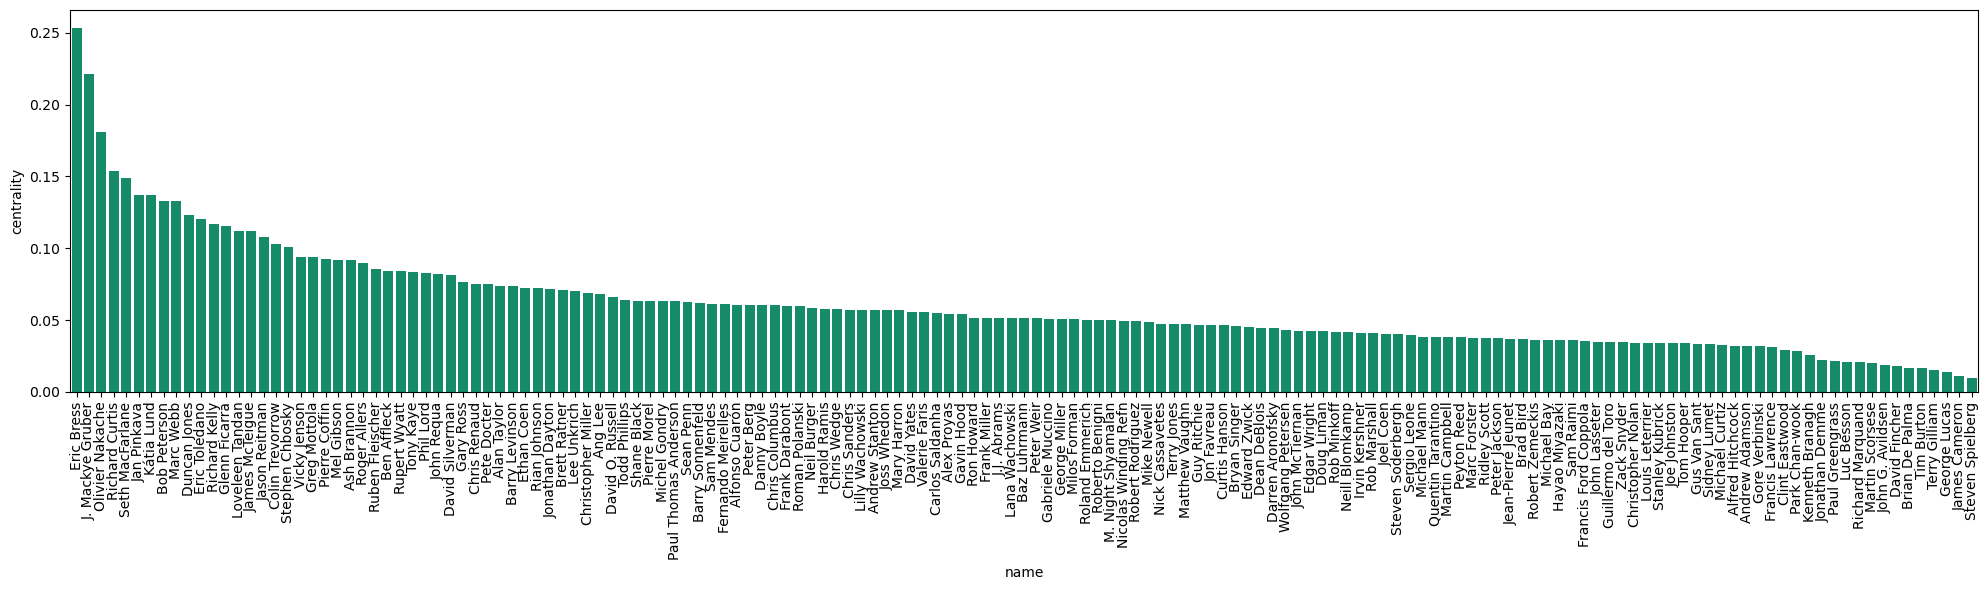

In [84]:
_directors = []
movies.query('votes > 500_000').directors.str.split(',').apply(lambda x: _directors.extend(x))
D = get_similarity_graph(
    movies=movies,
    directors=directors.loc[list(set(_directors))],
)
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality', ascending=False)
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(df, y='centrality', x='name', color=PALETTE_D[1], ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

Same plot as above, but considering only the popular movies of these directors:

Considering movies of 153 directors.
Considering 228 movies.


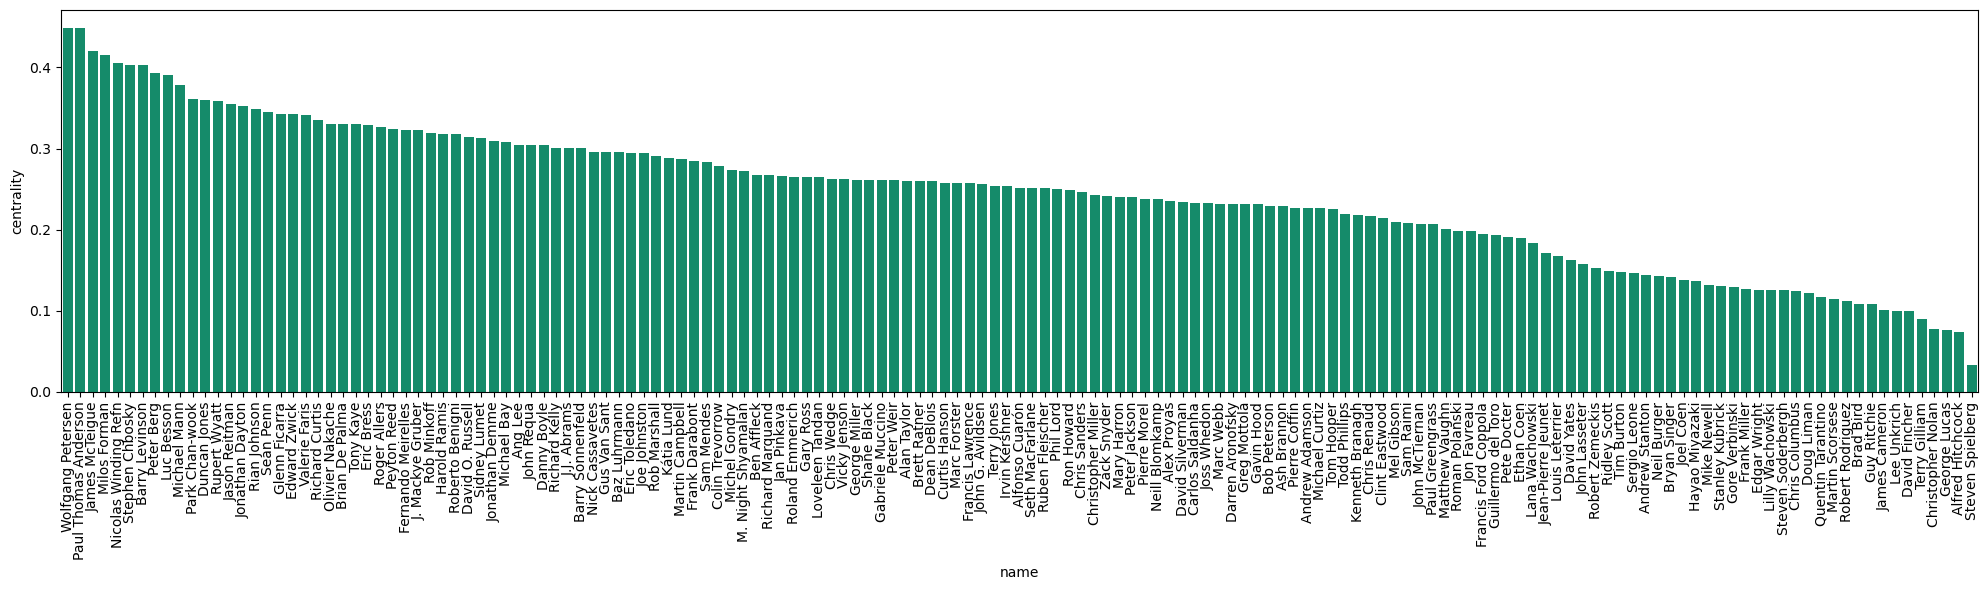

In [85]:
_directors = []
movies.query('votes > 500_000').directors.str.split(',').apply(lambda x: _directors.extend(x))
D = get_similarity_graph(
    movies=movies.query('votes > 500_000'),
    directors=directors.loc[list(set(_directors))],
)
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality', ascending=False)
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(df, y='centrality', x='name', color=PALETTE_D[1], ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

#### Now let's consider a larger group of successful directors and find clusters within them

In [86]:
D = get_similarity_graph(
    movies=movies,
    directors=directors[directors['rate-8.0'] > 1],
)

adjacency_data = {}
for idx, n in enumerate(nx.adjacency_data(D)['nodes']):
    adjacency_data[n['id']] = idx

Considering movies of 228 directors.
Considering 3998 movies.


Let's try different clustering algorithms and evaluate their performance:

Similarity score of community 0: 0.4874
Similarity score of community 1: 0.4613
Similarity score of community 2: 0.3321


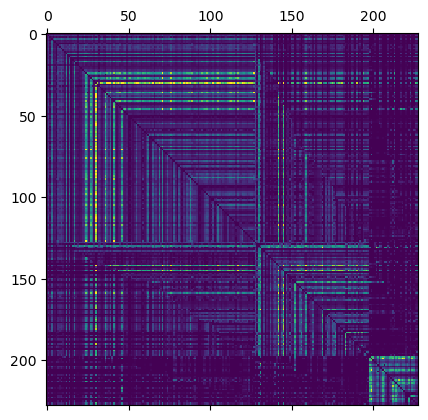

In [87]:
# Louvain clustering from sknetwork

clustering = skn.clustering.Louvain(resolution=1, shuffle_nodes=True, sort_clusters=True)
labels = clustering.fit_predict(nx.to_numpy_array(D))
order = np.concatenate([np.where(labels == label)[0] for label in range(max(labels)+1)])
plot_adjacency_matrix(D, order=order)

for label in range(max(labels)+1):
    idx = np.where(labels == label)[0]
    nodes = [n for n, i in adjacency_data.items() if i in idx]
    score = get_similarity_score(movies=movies, directors=directors.loc[nodes], verbose=False)
    print(f'Similarity score of community {label}: {score:.4f}')

Similarity score of community 0: 0.4874
Similarity score of community 1: 0.4663
Similarity score of community 2: 0.3055


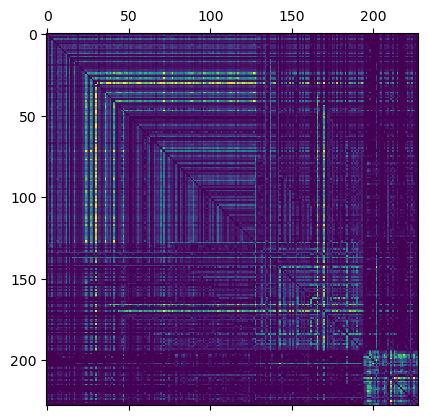

In [88]:
# Modularity communities from Networkx

coms = nx.community.greedy_modularity_communities(D, weight='weight')
plot_adjacency_matrix(D, order=np.array([adjacency_data[n] for com in coms for n in com]))

for idx, nodes in enumerate(coms):
    score = get_similarity_score(movies=movies, directors=directors.loc[nodes], verbose=False)
    print(f'Similarity score of community {idx}: {score:.4f}')

Similarity score of community 0: 0.3602
Similarity score of community 1: 0.4595
Similarity score of community 2: 0.5156
Similarity score of community 3: 0.4694


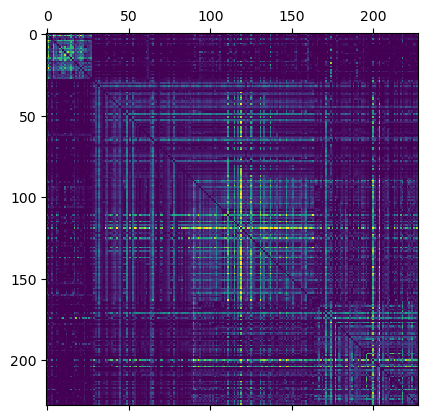

In [89]:
# Louvain communities from Networkx

coms = nx.community.louvain_communities(D, weight='weight')
plot_adjacency_matrix(D, order=np.array([adjacency_data[n] for com in coms for n in com]))

for idx, nodes in enumerate(coms):
    score = get_similarity_score(movies=movies, directors=directors.loc[list(nodes)], verbose=False)
    print(f'Similarity score of community {idx}: {score:.4f}')

Louvain clustering from both libraries performs similarly and the best for our graph.

Now that we have some clusters, let's look at the names and styles in these clusters.

In [90]:
coms = nx.community.louvain_communities(D, weight='weight')

primaryName  birthYear  deathYear         primaryProfession  \
nconst                                                                      
nm0000116   James Cameron       1954       <NA>  writer,producer,director   
nm0001129  Jonathan Demme       1944       2017  director,producer,writer   
nm0000231    Oliver Stone       1946       <NA>  director,producer,writer   
nm0000080    Orson Welles       1915       1985     actor,writer,director   
nm0601619   Michael Moore       1954       <NA>  director,producer,writer   

                                    knownForTitles  awardsNominated  \
nconst                                                                
nm0000116  tt0499549,tt0090605,tt0120338,tt1630029              137   
nm0001129  tt0102926,tt1084950,tt0368008,tt0107818               67   
nm0000231  tt0110632,tt0096969,tt0102138,tt0091763              112   
nm0000080  tt0040525,tt0033467,tt0057427,tt0052311               57   
nm0601619  tt0386032,tt1232207,tt0361596,tt0310793               79   

           awardsWon  hits-40  hits-45  hits-50  rate-8.0  rate-8.5  \
nconst                                                                
nm0000116         70        6        5        1         3         1   
nm0001129         31        2        1        1         2         2   
nm0000231         57        2        1        0         2         0   
nm0000080         33        2        1        0         2         0   
nm0601619         47        1        0        0         2         0   

               avg-3      avg-5     avg-10  genresPerMovie  genresExplored  
nconst                                                                      
nm0000116  49.961564    49.2563  41.656368        2.384615              11  
nm0001129  43.876718  39.307615  33.066821        2.416667               9  
nm0000231  42.061817  40.121576  36.868459        2.250000              13  
nm0000080  40.353561  37.559267   34.21558        1.972222              13  
nm0601619  39.601563  37.280595       <NA>        2.111111               6

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


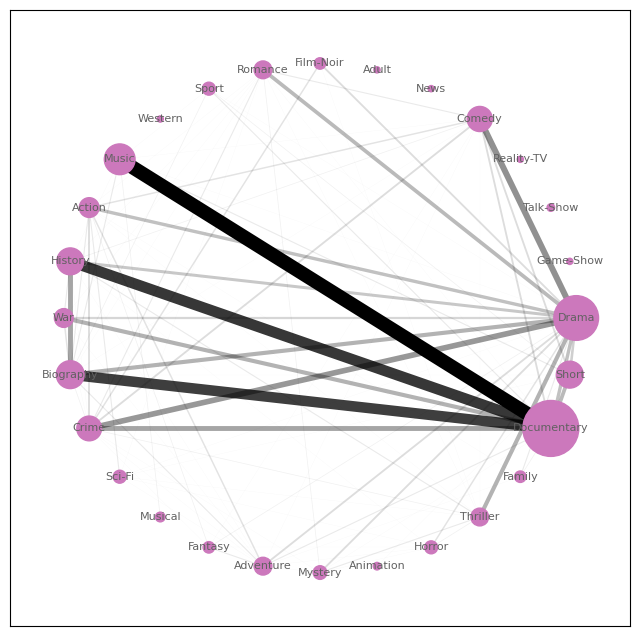

primaryName  birthYear  deathYear  \
nconst                                                  
nm0634240     Christopher Nolan       1970       <NA>   
nm0001392         Peter Jackson       1961       <NA>   
nm0000338  Francis Ford Coppola       1939       <NA>   
nm0000233     Quentin Tarantino       1963       <NA>   
nm0000229      Steven Spielberg       1946       <NA>   

                  primaryProfession                           knownForTitles  \
nconst                                                                         
nm0634240  writer,producer,director  tt0816692,tt1375666,tt6723592,tt0482571   
nm0001392  producer,director,writer  tt0120737,tt0167261,tt0360717,tt0092610   
nm0000338  producer,director,writer  tt0078788,tt0071562,tt0068646,tt0071360   
nm0000233     writer,actor,producer  tt7131622,tt0110912,tt0105236,tt0116367   
nm0000229  producer,writer,director  tt0083866,tt0108052,tt0082971,tt0120815   

           awardsNominated  awardsWon  hits-40  hits-45  hits-50  rate-8.0  \
nconst                                                                       
nm0634240              358        137        7        7        7         7   
nm0001392              270        137        4        3        3         3   
nm0000338               96         49        4        3        2         4   
nm0000233              421        161        8        7        4         7   
nm0000229              382        189       13        7        3         7   

           rate-8.5      avg-3      avg-5     avg-10  genresPerMovie  \
nconst                                                                 
nm0634240         4  56.359359   54.76424  48.277678        2.900000   
nm0001392         3  55.600284  48.992753  40.917419        2.692308   
nm0000338         3  54.015733  48.884288  42.252444        2.533333   
nm0000233         2  53.710729  52.175466  47.488598        2.250000   
nm0000229         2  52.930622  51.378904  48.343442        2.454545   

           genresExplored  
nconst                     
nm0634240               5  
nm0001392              10  
nm0000338              13  
nm0000233               9  
nm0000229              16

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


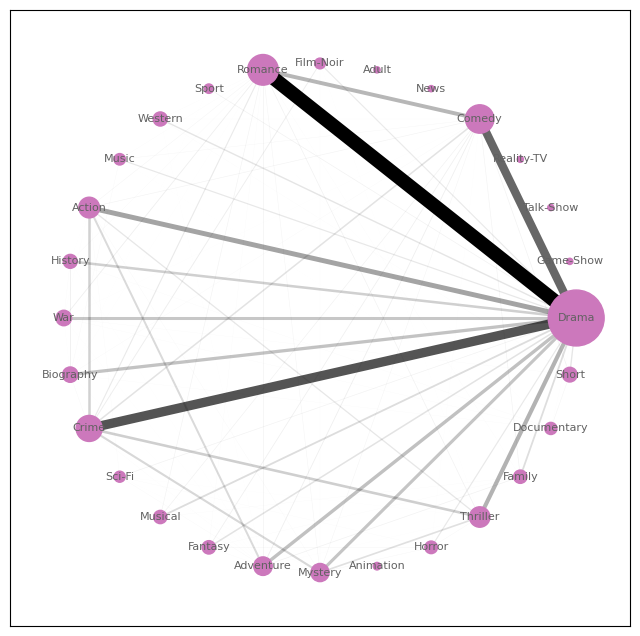

primaryName  birthYear  deathYear  \
nconst                                             
nm0000709  Robert Zemeckis       1952       <NA>   
nm0881279      Lee Unkrich       1967       <NA>   
nm0001053       Ethan Coen       1957       <NA>   
nm0001054        Joel Coen       1954       <NA>   
nm0594503   Hayao Miyazaki       1941       <NA>   

                                    primaryProfession  \
nconst                                                  
nm0000709                    producer,writer,director   
nm0881279   editorial_department,editor,miscellaneous   
nm0001053                    producer,writer,director   
nm0001054                    producer,writer,director   
nm0594503  animation_department,writer,art_department   

                                     knownForTitles  awardsNominated  \
nconst                                                                 
nm0000709   tt0118884,tt1907668,tt0088763,tt0109830               71   
nm0881279   tt0120363,tt0435761,tt2380307,tt0198781               58   
nm0001053   tt0116282,tt2042568,tt1019452,tt6412452              390   
nm0001054  tt6412452,tt2042568,tt0116282,tt10095582              438   
nm0594503   tt0096283,tt0245429,tt0347149,tt0119698              124   

           awardsWon  hits-40  hits-45  hits-50  rate-8.0  rate-8.5  \
nconst                                                                
nm0000709         34        8        3        2         2         2   
nm0881279         30        4        4        0         3         0   
nm0001053        112        5        3        0         3         0   
nm0001054        138        5        3        0         3         0   
nm0594503         77        7        4        1         7         1   

               avg-3      avg-5     avg-10  genresPerMovie  genresExplored  
nconst                                                                      
nm0000709  50.947567  47.926824  43.218293        2.750000               8  
nm0881279    49.0725       <NA>       <NA>        3.000000               1  
nm0001053  48.213155  45.843693  42.296259        2.611111               8  
nm0001054  48.213155  45.843693  42.296259        2.578947               8  
nm0594503  47.874943  46.127883  42.522689        2.888889               5

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


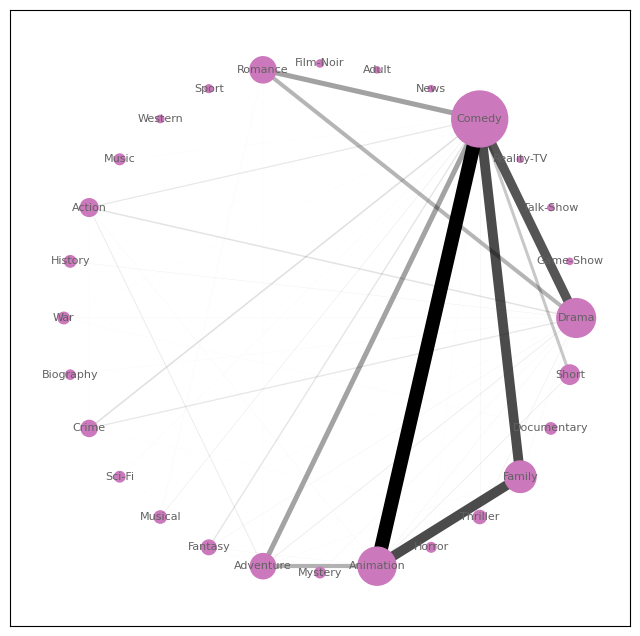

In [91]:
for idx, com in enumerate(coms):
    community = directors.loc[list(com)].sort_values(by='avg-3', ascending=False)
    display(community.head(5))
    G_genres = get_genre_coexistence_graph(movies=movies, directors=community, verbose=False)
    layout = nx.circular_layout(G_genres)
    draw_weighted_graph(G_genres, layout=layout, with_labels=True, normalize_wights=True)
    # plt.title(f'Community {idx}: {community[0].primaryName}')

Let's do the same thing for award-winning directors:

Considering movies of 900 directors.
Considering 6353 movies.


primaryName  birthYear  deathYear         primaryProfession  \
nconst                                                                        
nm0000229  Steven Spielberg       1946       <NA>  producer,writer,director   
nm0000217   Martin Scorsese       1942       <NA>   producer,director,actor   
nm0001054         Joel Coen       1954       <NA>  producer,writer,director   
nm0001392     Peter Jackson       1961       <NA>  producer,director,writer   
nm0955443       Yimou Zhang       1951       <NA>  director,writer,producer   

                                     knownForTitles  awardsNominated  \
nconst                                                                 
nm0000229   tt0083866,tt0108052,tt0082971,tt0120815              382   
nm0000217   tt0106226,tt0075314,tt0099685,tt0070379              429   
nm0001054  tt6412452,tt2042568,tt0116282,tt10095582              438   
nm0001392   tt0120737,tt0167261,tt0360717,tt0092610              270   
nm0955443   tt0473444,tt0101640,tt0385004,tt0299977              231   

           awardsWon  hits-40  hits-45  hits-50  rate-8.0  rate-8.5  \
nconst                                                                
nm0000229        189       13        7        3         7         2   
nm0000217        161       10        7        4        12         3   
nm0001054        138        5        3        0         3         0   
nm0001392        137        4        3        3         3         3   
nm0955443        131        1        0        0         2         0   

               avg-3      avg-5     avg-10  genresPerMovie  genresExplored  
nconst                                                                      
nm0000229  52.930622  51.378904  48.343442        2.454545              16  
nm0000217  51.938314  50.997257  47.283685        2.309524              15  
nm0001054  48.213155  45.843693  42.296259        2.578947               8  
nm0001392  55.600284  48.992753  40.917419        2.692308              10  
nm0955443  38.777165  37.507193  34.198667        2.210526               7

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


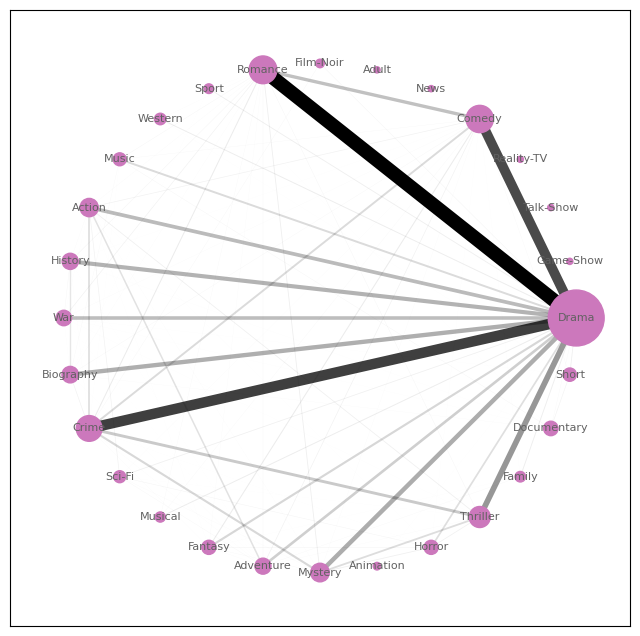

primaryName  birthYear  deathYear        primaryProfession  \
nconst                                                                     
nm1279296  Manuel Ferrara       1975       <NA>  actor,director,producer   

                                     knownForTitles  awardsNominated  \
nconst                                                                 
nm1279296  tt11309414,tt0869138,tt0459248,tt4538950              150   

           awardsWon  hits-40  hits-45  hits-50  rate-8.0  rate-8.5 avg-3  \
nconst                                                                      
nm1279296         39        0        0        0         0         0  <NA>   

          avg-5 avg-10  genresPerMovie  genresExplored  
nconst                                                  
nm1279296  <NA>   <NA>             1.0               0

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


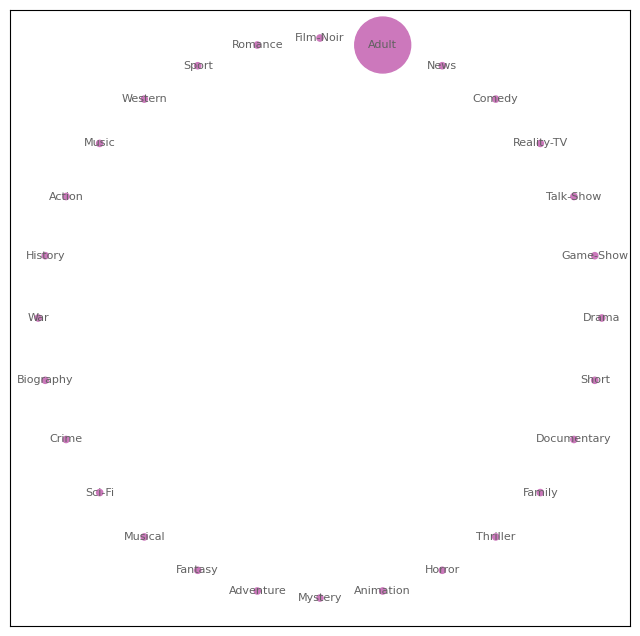

primaryName  birthYear  deathYear  \
nconst                                           
nm0004139  Murilo Salles       1950       <NA>   

                         primaryProfession  \
nconst                                       
nm0004139  cinematographer,director,writer   

                                    knownForTitles  awardsNominated  \
nconst                                                                
nm0004139  tt0133131,tt0115929,tt0093059,tt0334316               34   

           awardsWon  hits-40  hits-45  hits-50  rate-8.0  rate-8.5 avg-3  \
nconst                                                                      
nm0004139         24        0        0        0         0         0  <NA>   

          avg-5 avg-10  genresPerMovie  genresExplored  
nconst                                                  
nm0004139  <NA>   <NA>             NaN               0

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


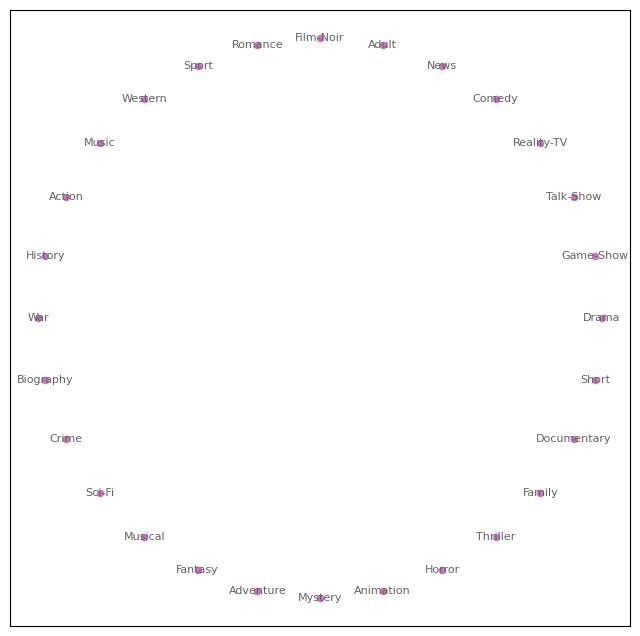

primaryName  birthYear  deathYear  \
nconst                                                   
nm0190859         Alfonso Cuarón       1961       <NA>   
nm0000142         Clint Eastwood       1930       <NA>   
nm0094435           Bong Joon Ho       1969       <NA>   
nm0634240      Christopher Nolan       1970       <NA>   
nm0327944  Alejandro G. Iñárritu       1963       <NA>   

                  primaryProfession                           knownForTitles  \
nconst                                                                         
nm0190859  producer,writer,director  tt0245574,tt6155172,tt0206634,tt1454468   
nm0000142   actor,producer,director  tt0105695,tt0112579,tt1205489,tt0405159   
nm0094435  writer,producer,director  tt1216496,tt6751668,tt1706620,tt3967856   
nm0634240  writer,producer,director  tt0816692,tt1375666,tt6723592,tt0482571   
nm0327944  producer,director,writer  tt0245712,tt1164999,tt2562232,tt1663202   

           awardsNominated  awardsWon  hits-40  hits-45  hits-50  rate-8.0  \
nconst                                                                       
nm0190859              439        254        3        3        0         0   
nm0000142              308        147        7        3        0         3   
nm0094435              256        143        1        0        0         1   
nm0634240              358        137        7        7        7         7   
nm0327944              279        122        3        0        0         1   

           rate-8.5      avg-3      avg-5     avg-10  genresPerMovie  \
nconst                                                                 
nm0190859         0  45.605509    42.2348       <NA>        2.444444   
nm0000142         0  47.122473  45.693854  42.315734        2.628571   
nm0094435         0  39.960484  36.923299       <NA>        2.666667   
nm0634240         4  56.359359   54.76424  48.277678        2.900000   
nm0327944         0  41.949604  37.726471       <NA>        1.833333   

           genresExplored  
nconst                     
nm0190859               7  
nm0000142              13  
nm0094435               3  
nm0634240               5  
nm0327944               3

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


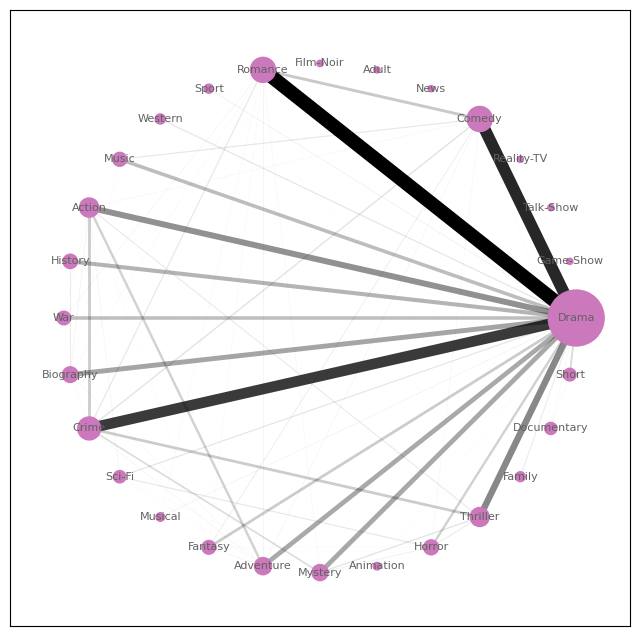

primaryName  birthYear  deathYear  \
nconst                                            
nm2143282  Lupita Nyong'o       1983       <NA>   
nm0075666   Joe Berlinger       1961       <NA>   
nm0001070      Bill Cosby       1937       <NA>   
nm0422605     Zhangke Jia       1970       <NA>   
nm0000116   James Cameron       1954       <NA>   

                             primaryProfession  \
nconst                                           
nm2143282          actress,producer,soundtrack   
nm0075666  producer,director,camera_department   
nm0001070        actor,writer,music_department   
nm0422605             producer,director,writer   
nm0000116             writer,producer,director   

                                    knownForTitles  awardsNominated  \
nconst                                                                
nm2143282  tt6857112,tt2488496,tt1825683,tt2024544              171   
nm0075666  tt0103888,tt2481498,tt0387412,tt0117293              116   
nm0001070  tt0063871,tt0058816,tt0093405,tt0086687               93   
nm0422605  tt0859765,tt2852400,tt3740778,tt7298400              158   
nm0000116  tt0499549,tt0090605,tt0120338,tt1630029              137   

           awardsWon  hits-40  hits-45  hits-50  rate-8.0  rate-8.5  \
nconst                                                                
nm2143282         84        0        0        0         0         0   
nm0075666         83        0        0        0         2         0   
nm0001070         72        0        0        0         1         0   
nm0422605         71        0        0        0         0         0   
nm0000116         70        6        5        1         3         1   

               avg-3      avg-5     avg-10  genresPerMovie  genresExplored  
nconst                                                                      
nm2143282       <NA>       <NA>       <NA>        2.000000               1  
nm0075666  33.101094  31.259254       <NA>        2.000000               4  
nm0001070       <NA>       <NA>       <NA>        2.000000               1  
nm0422605  26.468002  25.670711  21.123717        1.363636               6  
nm0000116  49.961564    49.2563  41.656368        2.384615              11

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


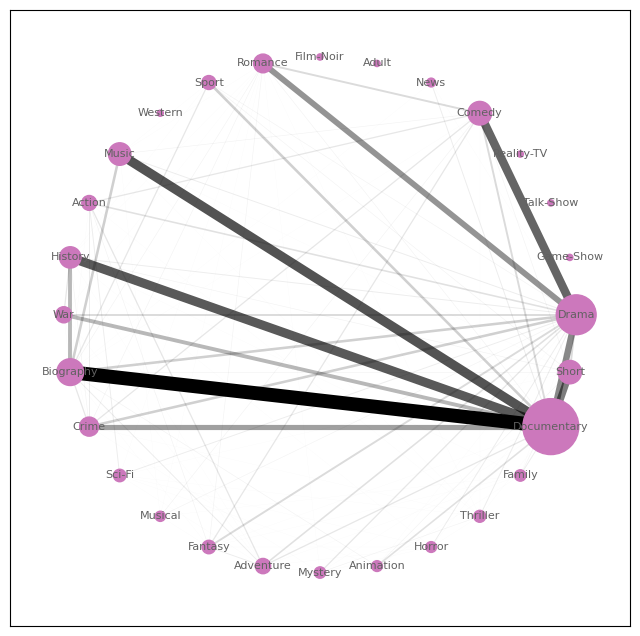

primaryName  birthYear  deathYear  \
nconst                                               
nm0000233  Quentin Tarantino       1963       <NA>   
nm0381116     Don Hertzfeldt       1976       <NA>   
nm0000264    Pedro Almodóvar       1949       <NA>   
nm0000095        Woody Allen       1935       <NA>   
nm0000204    Natalie Portman       1981       <NA>   

                                primaryProfession  \
nconst                                              
nm0000233                   writer,actor,producer   
nm0381116  producer,animation_department,director   
nm0000264              writer,director,soundtrack   
nm0000095                   writer,director,actor   
nm0000204             actress,producer,soundtrack   

                                    knownForTitles  awardsNominated  \
nconst                                                                
nm0000233  tt7131622,tt0110912,tt0105236,tt0116367              421   
nm0381116  tt0096697,tt2078648,tt4171032,tt0234588              191   
nm0000264  tt0101026,tt0287467,tt1189073,tt0095675              339   
nm0000095  tt0118954,tt0075686,tt0079522,tt0091167              347   
nm0000204  tt0110413,tt0376541,tt0947798,tt0434409              223   

           awardsWon  hits-40  hits-45  hits-50  rate-8.0  rate-8.5  \
nconst                                                                
nm0000233        161        8        7        4         7         2   
nm0381116        161        0        0        0         2         0   
nm0000264        156        1        0        0         0         0   
nm0000095        139        4        0        0         1         0   
nm0000204         88        0        0        0         0         0   

               avg-3      avg-5     avg-10  genresPerMovie  genresExplored  
nconst                                                                      
nm0000233  53.710729  52.175466  47.488598        2.250000               9  
nm0381116  28.524591  26.807165       <NA>        3.000000               4  
nm0000264  39.539368  38.458265  35.455258        2.263158               7  
nm0000095  42.353831  41.161361  38.865405        2.088889              11  
nm0000204       <NA>       <NA>       <NA>        3.000000               2

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


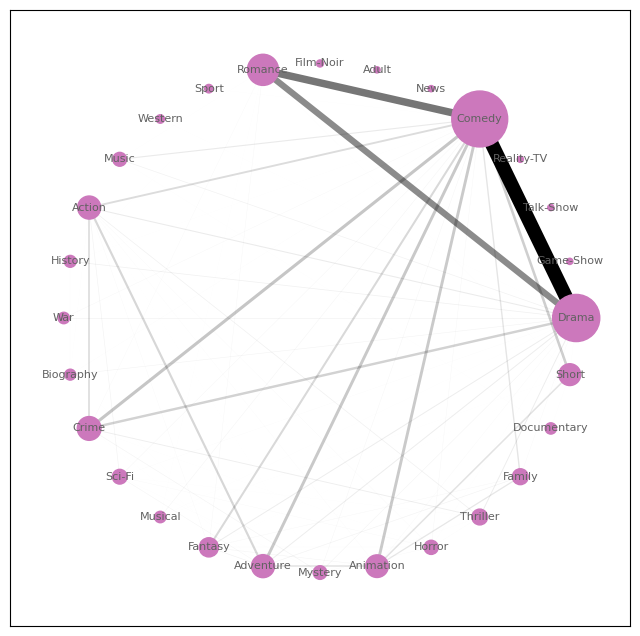

In [92]:
D = get_similarity_graph(
    movies=movies,
    directors=directors[directors['awardsWon'] > 20],
)

coms = nx.community.louvain_communities(D, weight='weight')

for idx, com in enumerate(coms):
    community = directors.loc[list(com)].sort_values(by='awardsWon', ascending=False)
    display(community.head(5))
    G_genres = get_genre_coexistence_graph(movies=movies, directors=community, verbose=False)
    layout = nx.circular_layout(G_genres)
    draw_weighted_graph(G_genres, layout=layout, with_labels=True, normalize_wights=True)
    # plt.title(f'Community {idx}: {community[0].primaryName}')

And for directors with average score more than 30:

Considering movies of 409 directors.
Considering 6094 movies.


primaryName  birthYear  deathYear         primaryProfession  \
nconst                                                                        
nm0000709   Robert Zemeckis       1952       <NA>  producer,writer,director   
nm0000040   Stanley Kubrick       1928       1999  director,writer,producer   
nm0000033  Alfred Hitchcock       1899       1980  director,producer,writer   
nm0001053        Ethan Coen       1957       <NA>  producer,writer,director   
nm0001054         Joel Coen       1954       <NA>  producer,writer,director   

                                     knownForTitles  awardsNominated  \
nconst                                                                 
nm0000709   tt0118884,tt1907668,tt0088763,tt0109830               71   
nm0000040   tt0072684,tt0062622,tt0066921,tt0093058               99   
nm0000033   tt0052357,tt0056869,tt0054215,tt0053125               71   
nm0001053   tt0116282,tt2042568,tt1019452,tt6412452              390   
nm0001054  tt6412452,tt2042568,tt0116282,tt10095582              438   

           awardsWon  hits-40  hits-45  hits-50  rate-8.0  rate-8.5  \
nconst                                                                
nm0000709         34        8        3        2         2         2   
nm0000040         43        9        5        1         7         0   
nm0000033         29        9        4        0         6         2   
nm0001053        112        5        3        0         3         0   
nm0001054        138        5        3        0         3         0   

               avg-3      avg-5     avg-10  genresPerMovie  genresExplored  
nconst                                                                      
nm0000709  50.947567  47.926824  43.218293        2.750000               8  
nm0000040  49.593339  49.043534   45.40516        2.500000              10  
nm0000033  48.282145  46.783902  43.713955        2.450000              16  
nm0001053  48.213155  45.843693  42.296259        2.611111               8  
nm0001054  48.213155  45.843693  42.296259        2.578947               8

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


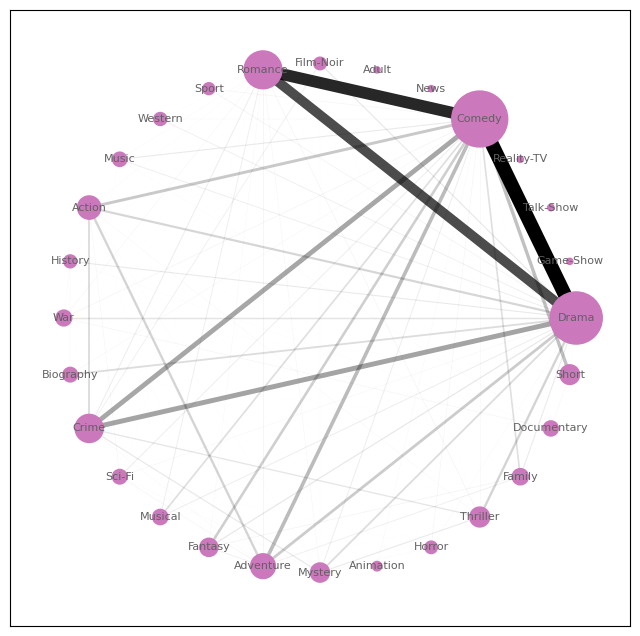

primaryName  birthYear  deathYear  \
nconst                                              
nm0001392     Peter Jackson       1961       <NA>   
nm0000229  Steven Spielberg       1946       <NA>   
nm0881279       Lee Unkrich       1967       <NA>   
nm0594503    Hayao Miyazaki       1941       <NA>   
nm0004056    Andrew Stanton       1965       <NA>   

                                    primaryProfession  \
nconst                                                  
nm0001392                    producer,director,writer   
nm0000229                    producer,writer,director   
nm0881279   editorial_department,editor,miscellaneous   
nm0594503  animation_department,writer,art_department   
nm0004056                       writer,actor,producer   

                                    knownForTitles  awardsNominated  \
nconst                                                                
nm0001392  tt0120737,tt0167261,tt0360717,tt0092610              270   
nm0000229  tt0083866,tt0108052,tt0082971,tt0120815              382   
nm0881279  tt0120363,tt0435761,tt2380307,tt0198781               58   
nm0594503  tt0096283,tt0245429,tt0347149,tt0119698              124   
nm0004056  tt2277860,tt0266543,tt0120623,tt0910970              101   

           awardsWon  hits-40  hits-45  hits-50  rate-8.0  rate-8.5  \
nconst                                                                
nm0001392        137        4        3        3         3         3   
nm0000229        189       13        7        3         7         2   
nm0881279         30        4        4        0         3         0   
nm0594503         77        7        4        1         7         1   
nm0004056         35        2        2        1         2         0   

               avg-3      avg-5     avg-10  genresPerMovie  genresExplored  
nconst                                                                      
nm0001392  55.600284  48.992753  40.917419        2.692308              10  
nm0000229  52.930622  51.378904  48.343442        2.454545              16  
nm0881279    49.0725       <NA>       <NA>        3.000000               1  
nm0594503  47.874943  46.127883  42.522689        2.888889               5  
nm0004056  46.653043   38.54741       <NA>        2.800000               2

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


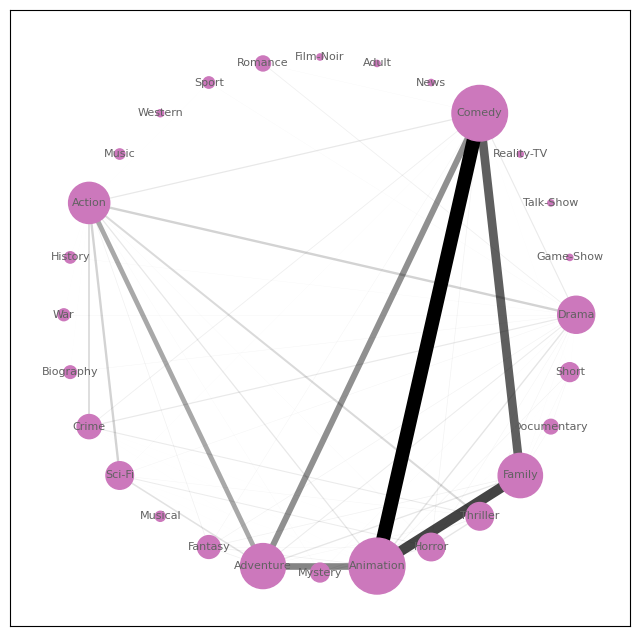

primaryName  birthYear  deathYear  \
nconst                                                 
nm0000116        James Cameron       1954       <NA>   
nm0601619        Michael Moore       1954       <NA>   
nm0005069          Spike Jonze       1969       <NA>   
nm0288144  Alastair Fothergill       1960       <NA>   
nm0001348        Werner Herzog       1942       <NA>   

                  primaryProfession                            knownForTitles  \
nconst                                                                          
nm0000116  writer,producer,director   tt0499549,tt0090605,tt0120338,tt1630029   
nm0601619  director,producer,writer   tt0386032,tt1232207,tt0361596,tt0310793   
nm0005069  producer,writer,director   tt0386117,tt1798709,tt0120188,tt0120601   
nm0288144  producer,director,writer  tt0296310,tt9253866,tt0795176,tt11989890   
nm0001348     director,writer,actor   tt0427312,tt0083946,tt0068182,tt0790724   

           awardsNominated  awardsWon  hits-40  hits-45  hits-50  rate-8.0  \
nconst                                                                       
nm0000116              137         70        6        5        1         3   
nm0601619               79         47        1        0        0         2   
nm0005069              180         64        2        0        0         3   
nm0288144               13          6        1        1        1         1   
nm0001348              122         58        0        0        0         3   

           rate-8.5      avg-3      avg-5     avg-10  genresPerMovie  \
nconst                                                                 
nm0000116         1  49.961564    49.2563  41.656368        2.384615   
nm0601619         0  39.601563  37.280595       <NA>        2.111111   
nm0005069         1  39.060187  34.950083  29.198831        2.058824   
nm0288144         1   37.24743       <NA>       <NA>        1.500000   
nm0001348         0  37.112128  36.375834  34.395328        1.796296   

           genresExplored  
nconst                     
nm0000116              11  
nm0601619               6  
nm0005069              13  
nm0288144               3  
nm0001348              21

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


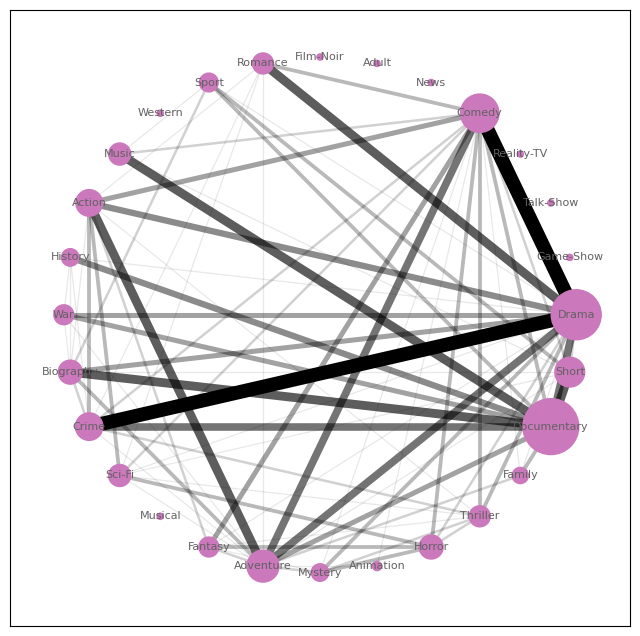

primaryName  birthYear  deathYear  \
nconst                                                  
nm0634240     Christopher Nolan       1970       <NA>   
nm0000338  Francis Ford Coppola       1939       <NA>   
nm0000233     Quentin Tarantino       1963       <NA>   
nm0000217       Martin Scorsese       1942       <NA>   
nm0000399         David Fincher       1962       <NA>   

                  primaryProfession                           knownForTitles  \
nconst                                                                         
nm0634240  writer,producer,director  tt0816692,tt1375666,tt6723592,tt0482571   
nm0000338  producer,director,writer  tt0078788,tt0071562,tt0068646,tt0071360   
nm0000233     writer,actor,producer  tt7131622,tt0110912,tt0105236,tt0116367   
nm0000217   producer,director,actor  tt0106226,tt0075314,tt0099685,tt0070379   
nm0000399  producer,director,writer  tt0443706,tt2267998,tt0114369,tt1285016   

           awardsNominated  awardsWon  hits-40  hits-45  hits-50  rate-8.0  \
nconst                                                                       
nm0634240              358        137        7        7        7         7   
nm0000338               96         49        4        3        2         4   
nm0000233              421        161        8        7        4         7   
nm0000217              429        161       10        7        4        12   
nm0000399              181         67        7        4        2         2   

           rate-8.5      avg-3      avg-5     avg-10  genresPerMovie  \
nconst                                                                 
nm0634240         4  56.359359   54.76424  48.277678        2.900000   
nm0000338         3  54.015733  48.884288  42.252444        2.533333   
nm0000233         2  53.710729  52.175466  47.488598        2.250000   
nm0000217         3  51.938314  50.997257  47.283685        2.309524   
nm0000399         2  51.770668  49.031727       <NA>        2.666667   

           genresExplored  
nconst                     
nm0634240               5  
nm0000338              13  
nm0000233               9  
nm0000217              15  
nm0000399               5

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


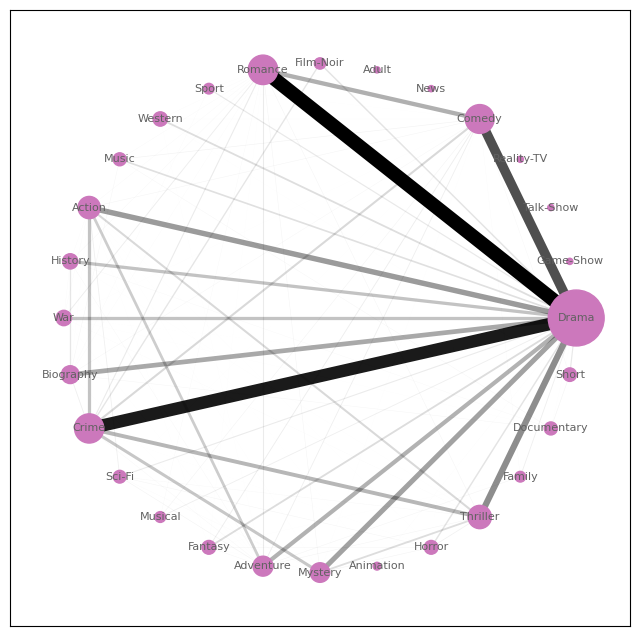

In [185]:
D = get_similarity_graph(
    movies=movies,
    directors=directors[directors['avg-3'] > 35],
)

coms = nx.community.louvain_communities(D, weight='weight')

for idx, com in enumerate(coms):
    community = directors.loc[list(com)].sort_values(by='avg-3', ascending=False)
    display(community.head(5))
    G_genres = get_genre_coexistence_graph(movies=movies, directors=community, verbose=False)
    layout = nx.circular_layout(G_genres)
    draw_weighted_graph(G_genres, layout=layout, with_labels=True, normalize_wights=True)
    # plt.title(f'Community {idx}: {community[0].primaryName}')